<h1 style="font-size: 36px;"><strong>Twitter Sentiment Analysis - A Complete Guide to Text Classification</strong></h1>


In this project, we aim to perform sentiment analysis on a large dataset of tweets. Sentiment analysis involves classifying the sentiment of text data, in this case, tweets, as positive or negative. This analysis can provide insights into public opinion on various topics.

The dataset used for this project is a Twitter sentiment analysis dataset (https://www.kaggle.com/datasets/kazanova/sentiment140) containing 1.6 million tweets. Each tweet is labeled with a sentiment: 0 for negative sentiment and 4 for positive sentiment. The dataset includes the following columns: target (sentiment label), ids (tweet ID), date (date of the tweet), flag (query flag), user (username), and text (tweet content).

The goals of this project are:
1. To clean and preprocess the tweet data.
2. To explore the data through various visualizations and descriptive statistics.
3. To build and evaluate machine learning and deep learning models for sentiment classification.


**Dataset Cleaning**

Data cleaning is a crucial step in any data analysis project. The primary goal is to preprocess the data and make it suitable for analysis. In this project, we will perform the following cleaning steps on the tweet dataset:

1. Remove special characters, hyperlinks, and mentions from the tweet text.
2. Convert all text to lowercase to ensure uniformity.
3. Remove stop words (common words that do not contribute much to the meaning of the text).
4. Perform lemmatization to reduce words to their base or root form.

After cleaning the data, we will split it into training and testing sets for model evaluation.

Also, note that we only used 5% of the dataset in this study due to computational limitations.

In [ ]:
import pandas as pd
import re
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
import nltk
from wordcloud import WordCloud, STOPWORDS

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Define stopwords and lemmatizer
eng_stops = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

# Function to clean tweet text
def cleandata(review_text):
    # Remove all the special characters
    new_review_text = re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", review_text)
    # Convert all letters to lower case
    words = new_review_text.lower().split()
    # Remove stop words
    words = [w for w in words if not w in eng_stops]
    # Lemmatizer
    words = [lemmatizer.lemmatize(word) for word in words]
    # Join all words back to text
    return " ".join(words)

# Load the dataset
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"

df = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)

# Map labels 0 and 4 to 0 and 1
df['target'] = df['target'].map({0: 0, 4: 1})

# Select 5% of the dataset
df_sample = df.sample(frac=0.05, random_state=42)

# Clean the tweet text
df_sample['clean_text'] = df_sample['text'].apply(lambda x: cleandata(x))

# Split the data into train and test sets
train_data, test_data = train_test_split(df_sample, test_size=0.2, random_state=42)

print("Data cleaning and splitting completed.")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Data cleaning and splitting completed.


**EDA**

Exploratory Data Analysis (EDA) is the process of analyzing and visualizing the data to gain insights into its structure and main characteristics. In this section, we will perform the following analyses on the cleaned tweet dataset:

1. **Distribution of Labels**: Visualize the distribution of sentiment labels (positive and negative).
2. **Word Cloud Visualization**: Create word clouds to visualize the most frequent words in positive and negative tweets.
3. **Most Frequent Words**: Identify and display the most frequent words in positive and negative tweets.
4. **Tweet Length Distribution**: Analyze the distribution of tweet lengths.
5. **Number of Words in Tweets**: Analyze the distribution of the number of words in tweets.

These analyses will help us understand the data better and guide us in building effective sentiment classification models.

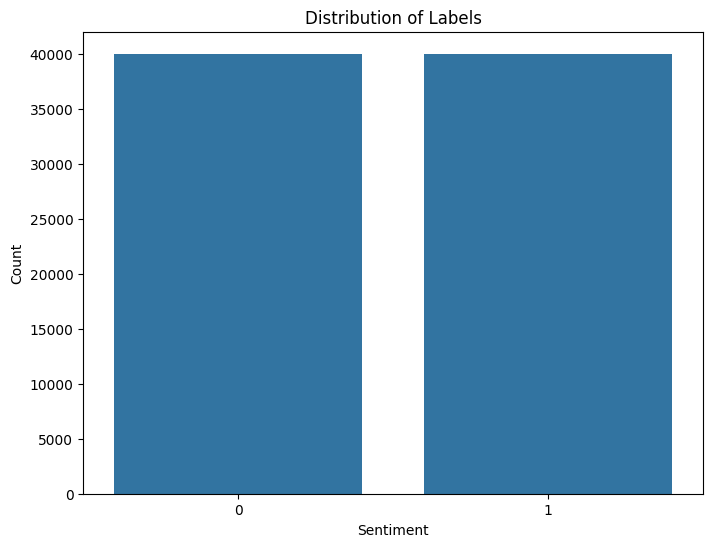

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of labels
plt.figure(figsize=(8, 6))
sns.countplot(x='target', data=df_sample)
plt.title('Distribution of Labels')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

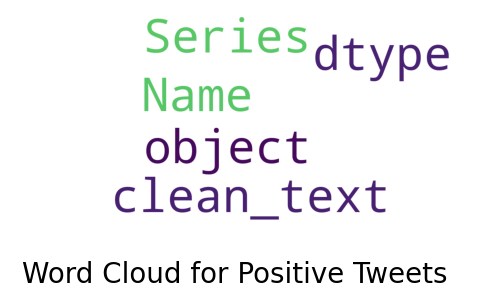

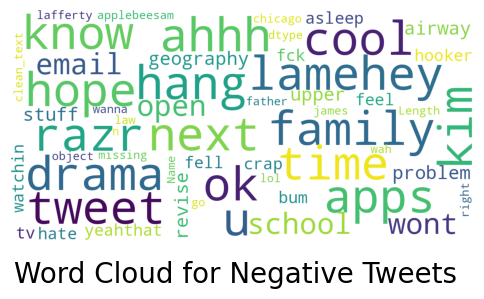

In [ ]:
# Function to generate word cloud
def generate_wordcloud(text, title=None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=STOPWORDS,
        max_words=200,
        max_font_size=40,
        scale=3,
        random_state=42
    ).generate(str(text))

    fig = plt.figure(1, figsize=(6, 6))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)
    plt.imshow(wordcloud)
    plt.show()

# Word cloud for positive tweets
positive_text = df_sample[df_sample['target'] == 4]['clean_text']
generate_wordcloud(positive_text, title='Word Cloud for Positive Tweets')

# Word cloud for negative tweets
negative_text = df_sample[df_sample['target'] == 0]['clean_text']
generate_wordcloud(negative_text, title='Word Cloud for Negative Tweets')

In [ ]:
# Most frequent words in positive tweets
positive_words = positive_text.str.split(expand=True).stack().value_counts()
print("Most frequent words in positive tweets:")
print(positive_words.head(10))

# Most frequent words in negative tweets
negative_words = negative_text.str.split(expand=True).stack().value_counts()
print("Most frequent words in negative tweets:")
print(negative_words.head(10))

Most frequent words in positive tweets:
Series([], Name: count, dtype: int64)
Most frequent words in negative tweets:
im       5193
get      2439
day      2408
go       2330
dont     2284
work     2264
cant     2223
like     2057
today    1875
want     1716
Name: count, dtype: int64


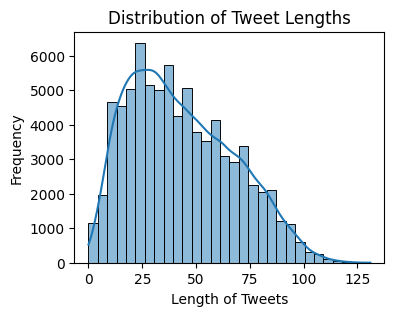

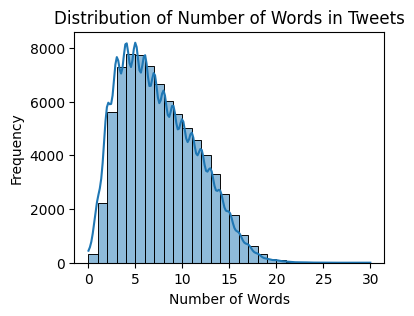

In [ ]:
# Length of tweets distribution

plt.figure(figsize=(4, 3))
sns.histplot(df_sample['clean_text'].apply(len), bins=30, kde=True)
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Length of Tweets')
plt.ylabel('Frequency')
plt.show()

# Number of words in tweets distribution

plt.figure(figsize=(4, 3))
sns.histplot(df_sample['clean_text'].apply(lambda x: len(x.split())), bins=30, kde=True)
plt.title('Distribution of Number of Words in Tweets')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

# **Method 1a: TF-IDF Vectorization with Unigram**


TF-IDF, which stands for Term Frequency-Inverse Document Frequency, is a statistical measure used to evaluate the importance of a word in a document relative to a collection of documents (corpus). It is a commonly used technique for text mining and information retrieval. The TF-IDF value increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus, which helps to adjust for the fact that some words appear more frequently in general.

**Term Frequency (TF)**

The Term Frequency (TF) of a word in a document is simply the number of times the word appears in that document. It is calculated as follows:

$$ \text{TF}(t) = \frac{\text{Number of times term } t \text{ appears in a document}}{\text{Total number of terms in the document}} $$


This measure helps to understand the frequency of a word in a specific document but does not account for the commonness or rarity of the word in the entire corpus.

**Inverse Document Frequency (IDF)**

The Inverse Document Frequency (IDF) is a measure of how much information the word provides, i.e., if it is common or rare across all documents. It is calculated as follows:

$$ \text{IDF}(t) = \log\left(\frac{\text{Total number of documents}}{\text{Number of documents with term } t}\right) $$

A high IDF score is assigned to words that are rare in the corpus, while common words like "the", "is", and "and" will have low IDF scores.

**TF-IDF Calculation**

The TF-IDF score for a term is the product of its TF and IDF scores:

$$ \text{TF-IDF}(t) = \text{TF}(t) \times \text{IDF}(t) $$

TF-IDF vectorization transforms the text data into numerical features that can be used by machine learning algorithms. By doing so, it captures the importance of words within documents in relation to the entire corpus, providing a way to weigh words more accurately based on their significance rather than their mere frequency.

In our sentiment analysis project, we use TF-IDF vectorization to convert the cleaned tweet texts into numerical feature vectors. These vectors serve as input to various machine learning classifiers, enabling us to evaluate their performance in predicting the sentiment of tweets.


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import re
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
!pip install catboost
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.multiclass import OneVsRestClassifier

# TF-IDF vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
train_tfidf_model = tfidf_vectorizer.fit_transform(train_data['clean_text'])
test_tfidf_model = tfidf_vectorizer.transform(test_data['clean_text'])


# Classifiers
cls = [CatBoostClassifier(verbose=0),
       DecisionTreeClassifier(),
       RandomForestClassifier(n_estimators=200),
       ExtraTreesClassifier(n_estimators=200),
       BaggingClassifier(n_estimators=20),
       AdaBoostClassifier(n_estimators=100),
       GradientBoostingClassifier(n_estimators=200),
       KNeighborsClassifier(),
       LogisticRegression(),
       LogisticRegression(C=1, penalty='l1', solver='liblinear'), # Lasso
       SGDClassifier(),
       XGBClassifier(random_state=22,learning_rate=0.9),
       LinearSVC(),
       ]

cls_name = []
accuracy = []
lbl_actual = test_data['target']

for cl in cls:
    model = cl.fit(train_tfidf_model, train_data['target'])
    lbl_pred = model.predict(test_tfidf_model)
    a = (100 * accuracy_score(lbl_pred, lbl_actual))
    a = round(a, 2)
    accuracy.append(a)
    cls_name.append(cl.__class__.__name__)
    print(f"{cls_name[-1]} Accuracy Score : {a}%")
    print(classification_report(lbl_pred, lbl_actual))

# Create a DataFrame for accuracy scores with vectorization method
accuracy_df = pd.DataFrame({'Classifier': cls_name, 'Vectorization': 'TF-IDF', 'Accuracy': accuracy})

# Adding a single hidden layer neural network using PyTorch
# Convert sparse matrices to dense for PyTorch
train_tfidf_model_dense = train_tfidf_model.toarray()
test_tfidf_model_dense = test_tfidf_model.toarray()

# Encode labels
le = LabelEncoder()
train_labels = le.fit_transform(train_data['target'])
test_labels = le.transform(test_data['target'])

# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define neural network model using nn.Sequential
input_dim = train_tfidf_model_dense.shape[1]
hidden_dim = 128
output_dim = 1

mlp_model = nn.Sequential(
    nn.Linear(input_dim, hidden_dim),
    nn.ReLU(),
    nn.Linear(hidden_dim, output_dim),
    nn.Sigmoid()
).to(device)

# Define loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

# Convert data to PyTorch tensors and move to the appropriate device
train_tfidf_tensor = torch.tensor(train_tfidf_model_dense, dtype=torch.float32).to(device)
test_tfidf_tensor = torch.tensor(test_tfidf_model_dense, dtype=torch.float32).to(device)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.float32).unsqueeze(1).to(device)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.float32).unsqueeze(1).to(device)

# Training loop
for epoch in range(300):
    mlp_model.train()
    optimizer.zero_grad()
    outputs = mlp_model(train_tfidf_tensor)
    loss = criterion(outputs, train_labels_tensor)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Evaluate model
mlp_model.eval()
with torch.no_grad():
    nn_pred = mlp_model(test_tfidf_tensor).squeeze().round().cpu().numpy()
    nn_accuracy = round(100 * accuracy_score(test_labels, nn_pred), 2)
    print(f"Neural Network Accuracy Score : {nn_accuracy}%")
    print(classification_report(test_labels, nn_pred))

# Add neural network results to DataFrame
nn_results = pd.DataFrame({'Classifier': ['Neural Network'], 'Vectorization': 'TF-IDF', 'Accuracy': [nn_accuracy]})
accuracy_df = pd.concat([accuracy_df, nn_results], ignore_index=True)
print(accuracy_df)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 5.6 MB/s eta 0:00:00
CatBoostClassifier Accuracy Score : 74.42%
              precision    recall  f1-score   support

           0       0.69      0.77      0.73      7183
           1       0.80      0.72      0.76      8817

    accuracy                           0.74     16000
   macro avg       0.74      0.75      0.74     16000
weighted avg       0.75      0.74      0.74     16000

DecisionTreeClassifier Accuracy Score : 68.28%
              precision    recall  f1-score   support

           0       0.67      0.69      0.68      7852
           1       0.69      0.68      0.69      8148

    accuracy                           0.68     16000
   macro avg       0.68      0.68      0.68     16000
weighted avg       0.68      0.68      0.68     16000

RandomForestClassifier Accuracy Score : 73.51%
              precision    recall  f1-score   support

           0       0.73      0.74      0.73      7908
           1       0

# **Method 1b: TF-IDF Vectorization with N grams**

TF-IDF can be extended to use N-grams, which are contiguous sequences of N items (words) from a given text. This approach captures more contextual information by considering combinations of words rather than individual words alone. For example, bigrams (N=2) will capture pairs of consecutive words, while trigrams (N=3) will capture triplets.

Incorporating N-grams into TF-IDF allows the model to account for word dependencies and phrases, providing richer and more informative features for text data. This is particularly useful for understanding the sentiment and meaning in sentences where context plays a crucial role.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import re
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
!pip install catboost
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.multiclass import OneVsRestClassifier


# TF-IDF vectorization
N=2 # N grams. N=1 means only unigrams, N=2 means unigrams and bigrams etc

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, N),max_features=1000)
train_tfidf_model = tfidf_vectorizer.fit_transform(train_data['clean_text'])
test_tfidf_model = tfidf_vectorizer.transform(test_data['clean_text'])

# Classifiers
cls = [CatBoostClassifier(verbose=0),
       DecisionTreeClassifier(),
       RandomForestClassifier(n_estimators=200),
       ExtraTreesClassifier(n_estimators=200),
       BaggingClassifier(n_estimators=20),
       AdaBoostClassifier(n_estimators=100),
       GradientBoostingClassifier(n_estimators=200),
       KNeighborsClassifier(),
       LogisticRegression(),
       LogisticRegression(C=1, penalty='l1', solver='liblinear'), # Lasso
       SGDClassifier(),
       XGBClassifier(random_state=22,learning_rate=0.9),
       LinearSVC(),
       ]

cls_name = []
accuracy = []
lbl_actual = test_data['target']

for cl in cls:
    model = cl.fit(train_tfidf_model, train_data['target'])
    lbl_pred = model.predict(test_tfidf_model)
    a = (100 * accuracy_score(lbl_pred, lbl_actual))
    a = round(a, 2)
    accuracy.append(a)
    cls_name.append(cl.__class__.__name__)
    print(f"{cls_name[-1]} Accuracy Score : {a}%")
    print(classification_report(lbl_pred, lbl_actual))

# Create a DataFrame for accuracy scores with vectorization method
accuracy_df = pd.DataFrame({'Classifier': cls_name, 'Vectorization': 'TF-IDF Ngrams', 'Accuracy': accuracy})

# Adding a single hidden layer neural network using PyTorch
# Convert sparse matrices to dense for PyTorch
train_tfidf_model_dense = train_tfidf_model.toarray()
test_tfidf_model_dense = test_tfidf_model.toarray()

# Encode labels
le = LabelEncoder()
train_labels = le.fit_transform(train_data['target'])
test_labels = le.transform(test_data['target'])

# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define neural network model using nn.Sequential
input_dim = train_tfidf_model_dense.shape[1]
hidden_dim = 128
output_dim = 1

mlp_model = nn.Sequential(
    nn.Linear(input_dim, hidden_dim),
    nn.ReLU(),
    nn.Linear(hidden_dim, output_dim),
    nn.Sigmoid()
).to(device)

# Define loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

# Convert data to PyTorch tensors and move to the appropriate device
train_tfidf_tensor = torch.tensor(train_tfidf_model_dense, dtype=torch.float32).to(device)
test_tfidf_tensor = torch.tensor(test_tfidf_model_dense, dtype=torch.float32).to(device)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.float32).unsqueeze(1).to(device)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.float32).unsqueeze(1).to(device)

# Training loop
for epoch in range(300):
    mlp_model.train()
    optimizer.zero_grad()
    outputs = mlp_model(train_tfidf_tensor)
    loss = criterion(outputs, train_labels_tensor)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Evaluate model
mlp_model.eval()
with torch.no_grad():
    nn_pred = mlp_model(test_tfidf_tensor).squeeze().round().cpu().numpy()
    nn_accuracy = round(100 * accuracy_score(test_labels, nn_pred), 2)
    print(f"Neural Network Accuracy Score : {nn_accuracy}%")
    print(classification_report(test_labels, nn_pred))

# Add neural network results to DataFrame
nn_results = pd.DataFrame({'Classifier': ['Neural Network'], 'Vectorization': 'TF-IDF Ngrams', 'Accuracy': [nn_accuracy]})
accuracy_df = pd.concat([accuracy_df, nn_results], ignore_index=True)
print(accuracy_df)

CatBoostClassifier Accuracy Score : 74.44%
              precision    recall  f1-score   support

           0       0.69      0.77      0.73      7206
           1       0.79      0.72      0.76      8794

    accuracy                           0.74     16000
   macro avg       0.74      0.75      0.74     16000
weighted avg       0.75      0.74      0.75     16000

DecisionTreeClassifier Accuracy Score : 68.36%
              precision    recall  f1-score   support

           0       0.68      0.69      0.68      7868
           1       0.69      0.68      0.69      8132

    accuracy                           0.68     16000
   macro avg       0.68      0.68      0.68     16000
weighted avg       0.68      0.68      0.68     16000

RandomForestClassifier Accuracy Score : 73.55%
              precision    recall  f1-score   support

           0       0.73      0.74      0.73      7843
           1       0.75      0.73      0.74      8157

    accuracy                           0.74  

# **Method 2: Word2Vec Trained from Scratch**

**Word2Vec: Understanding the Basics**

Word2Vec is a popular technique for natural language processing tasks, especially for converting text data into numerical vectors that can be used by machine learning models. Developed by researchers at Google, Word2Vec captures semantic relationships between words by training on a large corpus of text. It uses a neural network model to learn word associations from a large dataset of text.

**How Word2Vec Works**

Word2Vec comes in two flavors: Continuous Bag of Words (CBOW) and Skip-gram. Both models learn to predict the context of words in a sentence. Here’s how they work:

1. **Continuous Bag of Words (CBOW)**: This model predicts the current word based on the context of surrounding words. It uses multiple context words to predict the target word. For instance, in the sentence "the cat sits on the mat", CBOW would use the words "the", "sits", "on", and "the" to predict the word "cat".

2. **Skip-gram**: This model works in reverse of CBOW. It uses the current word to predict the surrounding context words. Using the same example, Skip-gram would take "cat" as the input and try to predict "the", "sits", "on", and "the". Skip-gram generally works better with a larger dataset and can capture more subtle relationships in the data.

**Training Word2Vec**

Word2Vec represents words as vectors in a continuous vector space, where words that share common contexts are located in close proximity to one another in the space. The steps involved in training Word2Vec are as follows:

1. **Context Window**: A window size is defined around the target word, which determines the number of surrounding words to consider for context. For example, if the window size is 2, the context words will include the two words before and the two words after the target word.

2. **Word Pairs Generation**: For CBOW, word pairs are generated by taking the context words as inputs and the target word as the output. For Skip-gram, the target word is the input, and the context words are the output.

3. **Neural Network Training**: The word pairs generated are used to train a shallow neural network. The input layer represents the words as one-hot encoded vectors, and the hidden layer transforms these into dense word vectors. The output layer predicts the probability of context words for a given target word (Skip-gram) or the target word for given context words (CBOW).

4. **Optimization**: The neural network is optimized using techniques such as negative sampling or hierarchical softmax to efficiently compute the loss and update the weights.


Below, we train a Word2Vec model from scratch on our dataset of tweets and use the resulting embeddings to perform sentiment classification with various machine learning classifiers. By averaging the word vectors for each tweet, we create document vectors that serve as inputs to our classifiers.

While we chose to use the Skip-gram model for this task, testing and considering the CBOW model could also yield valuable insights and potentially improve the results. Both approaches have their strengths and might perform differently depending on the specific dataset and application.

In [ ]:
import pandas as pd
import re
from gensim.models import Word2Vec
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
!pip install catboost
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Train Word2Vec model
w2v_model = Word2Vec(sentences=train_data['clean_text'], vector_size=300, window=5, min_count=2, workers=4, sg=1)

# Function to average word vectors for each tweet
def avg_word_vectors(words, model, vocabulary, num_features):
    feature_vec = np.zeros((num_features,), dtype="float32")
    n_words = 0
    for word in words:
        if word in vocabulary:
            n_words += 1
            feature_vec = np.add(feature_vec, model.wv[word])
    if n_words > 0:
        feature_vec = np.divide(feature_vec, n_words)
    return feature_vec

# Get the average word vectors for train and test data
vocabulary = set(w2v_model.wv.index_to_key)
train_word2vec_model = np.array([avg_word_vectors(tweet, w2v_model, vocabulary, 300) for tweet in train_data['clean_text']])
test_word2vec_model = np.array([avg_word_vectors(tweet, w2v_model, vocabulary, 300) for tweet in test_data['clean_text']])

# Classifiers
cls = [CatBoostClassifier(verbose=0),
       DecisionTreeClassifier(),
       RandomForestClassifier(n_estimators=200),
       ExtraTreesClassifier(n_estimators=200),
       BaggingClassifier(n_estimators=20),
       AdaBoostClassifier(n_estimators=100),
       GradientBoostingClassifier(n_estimators=200),
       KNeighborsClassifier(),
       LogisticRegression(),
       LogisticRegression(C=1, penalty='l1', solver='liblinear'), # Lasso
       SGDClassifier(),
       XGBClassifier(random_state=22,learning_rate=0.9),
       LinearSVC(),
       ]

# Evaluate classifiers with Word2Vec vectorization
cls_name = []
accuracy = []
lbl_actual = test_data['target']

for cl in cls:
    model = cl.fit(train_word2vec_model, train_data['target'])
    lbl_pred = model.predict(test_word2vec_model)
    a = (100 * accuracy_score(lbl_pred, lbl_actual))
    a = round(a, 2)
    accuracy.append(a)
    cls_name.append(cl.__class__.__name__)
    print(f"{cls_name[-1]} Accuracy Score : {a}%")
    print(classification_report(lbl_pred, lbl_actual))

# Create a DataFrame for Word2Vec accuracy scores
accuracy_df = pd.DataFrame({'Classifier': cls_name, 'Vectorization': 'Word2Vec', 'Accuracy': accuracy})

# Adding a single hidden layer neural network using PyTorch
# Encode labels
le = LabelEncoder()
train_labels = le.fit_transform(train_data['target'])
test_labels = le.transform(test_data['target'])

# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define neural network model using nn.Sequential
input_dim = train_word2vec_model.shape[1]
hidden_dim = 128
output_dim = 1

mlp_model = nn.Sequential(
    nn.Linear(input_dim, hidden_dim),
    nn.ReLU(),
    nn.Linear(hidden_dim, output_dim),
    nn.Sigmoid()
).to(device)

# Define loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

# Convert data to PyTorch tensors and move to the appropriate device
train_word2vec_tensor = torch.tensor(train_word2vec_model, dtype=torch.float32).to(device)
test_word2vec_tensor = torch.tensor(test_word2vec_model, dtype=torch.float32).to(device)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.float32).unsqueeze(1).to(device)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.float32).unsqueeze(1).to(device)

# Training loop
for epoch in range(300):
    mlp_model.train()
    optimizer.zero_grad()
    outputs = mlp_model(train_word2vec_tensor)
    loss = criterion(outputs, train_labels_tensor)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Evaluate model
mlp_model.eval()
with torch.no_grad():
    nn_pred = mlp_model(test_word2vec_tensor).squeeze().round().cpu().numpy()
    nn_accuracy = round(100 * accuracy_score(test_labels, nn_pred), 2)
    print(f"Neural Network Accuracy Score : {nn_accuracy}%")
    print(classification_report(test_labels, nn_pred))

# Add neural network results to DataFrame
nn_results = pd.DataFrame({'Classifier': ['Neural Network'], 'Vectorization': 'Word2Vec', 'Accuracy': [nn_accuracy]})
accuracy_df = pd.concat([accuracy_df, nn_results], ignore_index=True)
print(accuracy_df)


CatBoostClassifier Accuracy Score : 61.13%
              precision    recall  f1-score   support

           0       0.63      0.61      0.62      8364
           1       0.59      0.62      0.60      7636

    accuracy                           0.61     16000
   macro avg       0.61      0.61      0.61     16000
weighted avg       0.61      0.61      0.61     16000

DecisionTreeClassifier Accuracy Score : 54.01%
              precision    recall  f1-score   support

           0       0.54      0.54      0.54      7989
           1       0.54      0.54      0.54      8011

    accuracy                           0.54     16000
   macro avg       0.54      0.54      0.54     16000
weighted avg       0.54      0.54      0.54     16000

RandomForestClassifier Accuracy Score : 60.56%
              precision    recall  f1-score   support

           0       0.63      0.60      0.62      8394
           1       0.58      0.61      0.60      7606

    accuracy                           0.61  

# **Method 3: Doc2vec Trained from Scratch**

**Doc2Vec: Understanding the Basics**

Doc2Vec is an extension of the Word2Vec technique, tailored for generating vector representations of entire documents rather than individual words. Developed by the same researchers at Google who created Word2Vec, Doc2Vec captures semantic relationships between sentences and paragraphs, making it highly effective for various natural language processing tasks.

**How Doc2Vec Works**

Doc2Vec comes in two primary forms: Distributed Memory (DM) and Distributed Bag of Words (DBOW). Both models learn to represent documents as dense vectors by training on a large corpus of text. Here's how they function:

1. **Distributed Memory (DM)**: This model predicts a target word using both the surrounding context words and a unique document vector. The document vector acts as a memory that remembers what the document is about. For instance, in the sentence "the cat sits on the mat" from a specific document, DM uses the words "the", "sits", "on", and "the" along with the document vector to predict the word "cat".
2. **Distributed Bag of Words (DBOW)**: This model operates somewhat like the Skip-gram model in Word2Vec. It predicts context words given a document vector without considering the order of words. Using the same example, DBOW would use the document vector to predict the words "the", "sits", "on", and "the" from the document containing the sentence "the cat sits on the mat". DBOW typically requires more data but can capture nuanced document-level relationships.

**Training Doc2Vec**

Doc2Vec represents documents as vectors in a continuous vector space, where documents sharing similar contexts are placed closer to one another. The steps involved in training Doc2Vec are as follows:

1. **Context Window**: Define a window size around the target word, determining the number of surrounding words to consider for context. For instance, if the window size is 2, the context words include the two words before and after the target word.

2. **Tagged Documents**: Each document is tagged with a unique identifier. These tagged documents are used to create document-word pairs for training. In DM, both the document tag and context words are used to predict the target word. In DBOW, the document tag predicts context words.

3. **Neural Network Training**: The word-document pairs generated are used to train a neural network. The input layer represents the words and document tags as one-hot encoded vectors, while the hidden layer transforms these into dense vectors. The output layer predicts the probability of context words given a document tag (DBOW) or the target word given context words and a document tag (DM).

4. **Optimization**: The neural network is optimized using techniques such as negative sampling or hierarchical softmax to efficiently compute the loss and update the weights.

Below, we train a Doc2Vec model from scratch on our dataset of tweets and use the resulting embeddings to perform sentiment classification with various machine learning classifiers. By inferring vectors for each document (tweet), we create document vectors that serve as inputs to our classifiers.

While we chose to use the Distributed Memory model for this task, experimenting with the Distributed Bag of Words model could also provide valuable insights and potentially improve the results. Both approaches have their strengths and might perform differently depending on the specific dataset and application.

In [ ]:
import pandas as pd
import re
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
!pip install catboost
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Prepare data for Doc2Vec
train_tagged = [TaggedDocument(words=_d.split(), tags=[str(i)]) for i, _d in enumerate(train_data['clean_text'])]
test_tagged = [TaggedDocument(words=_d.split(), tags=[str(i)]) for i, _d in enumerate(test_data['clean_text'])]

# Train Doc2Vec model
d2v_model = Doc2Vec(vector_size=300, window=5, min_count=2, workers=4, epochs=40)
d2v_model.build_vocab(train_tagged)
d2v_model.train(train_tagged, total_examples=d2v_model.corpus_count, epochs=d2v_model.epochs)

# Generate document vectors
train_doc2vec_model = np.array([d2v_model.infer_vector(doc.words) for doc in train_tagged])
test_doc2vec_model = np.array([d2v_model.infer_vector(doc.words) for doc in test_tagged])

# Classifiers
cls = [CatBoostClassifier(verbose=0),
       DecisionTreeClassifier(),
       RandomForestClassifier(n_estimators=200),
       ExtraTreesClassifier(n_estimators=200),
       BaggingClassifier(n_estimators=20),
       AdaBoostClassifier(n_estimators=100),
       GradientBoostingClassifier(n_estimators=200),
       KNeighborsClassifier(),
       LogisticRegression(),
       LogisticRegression(C=1, penalty='l1', solver='liblinear'), # Lasso
       SGDClassifier(),
       XGBClassifier(random_state=22,learning_rate=0.9),
       LinearSVC(),
       ]

# Evaluate classifiers with Doc2Vec vectorization
cls_name = []
accuracy = []
lbl_actual = test_data['target']

for cl in cls:
    model = cl.fit(train_doc2vec_model, train_data['target'])
    lbl_pred = model.predict(test_doc2vec_model)
    a = (100 * accuracy_score(lbl_pred, lbl_actual))
    a = round(a, 2)
    accuracy.append(a)
    cls_name.append(cl.__class__.__name__)
    print(f"{cls_name[-1]} Accuracy Score : {a}%")
    print(classification_report(lbl_pred, lbl_actual))

# Create a DataFrame for Doc2Vec accuracy scores
accuracy_df = pd.DataFrame({'Classifier': cls_name, 'Vectorization': 'Doc2Vec', 'Accuracy': accuracy})

# Adding a single hidden layer neural network using PyTorch
# Encode labels
le = LabelEncoder()
train_labels = le.fit_transform(train_data['target'])
test_labels = le.transform(test_data['target'])

# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define neural network model using nn.Sequential
input_dim = train_doc2vec_model.shape[1]
hidden_dim = 128
output_dim = 1

mlp_model = nn.Sequential(
    nn.Linear(input_dim, hidden_dim),
    nn.ReLU(),
    nn.Linear(hidden_dim, output_dim),
    nn.Sigmoid()
).to(device)

# Define loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

# Convert data to PyTorch tensors and move to the appropriate device
train_doc2vec_tensor = torch.tensor(train_doc2vec_model, dtype=torch.float32).to(device)
test_doc2vec_tensor = torch.tensor(test_doc2vec_model, dtype=torch.float32).to(device)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.float32).unsqueeze(1).to(device)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.float32).unsqueeze(1).to(device)

# Training loop
for epoch in range(300):
    mlp_model.train()
    optimizer.zero_grad()
    outputs = mlp_model(train_doc2vec_tensor)
    loss = criterion(outputs, train_labels_tensor)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Evaluate model
mlp_model.eval()
with torch.no_grad():
    nn_pred = mlp_model(test_doc2vec_tensor).squeeze().round().cpu().numpy()
    nn_accuracy = round(100 * accuracy_score(test_labels, nn_pred), 2)
    print(f"Neural Network Accuracy Score : {nn_accuracy}%")
    print(classification_report(test_labels, nn_pred))

# Add neural network results to DataFrame
nn_results = pd.DataFrame({'Classifier': ['Neural Network'], 'Vectorization': 'Doc2Vec', 'Accuracy': [nn_accuracy]})
accuracy_df = pd.concat([accuracy_df, nn_results], ignore_index=True)
print(accuracy_df)


CatBoostClassifier Accuracy Score : 69.55%
              precision    recall  f1-score   support

           0       0.70      0.69      0.70      8055
           1       0.69      0.70      0.69      7945

    accuracy                           0.70     16000
   macro avg       0.70      0.70      0.70     16000
weighted avg       0.70      0.70      0.70     16000

DecisionTreeClassifier Accuracy Score : 54.7%
              precision    recall  f1-score   support

           0       0.55      0.55      0.55      8089
           1       0.54      0.55      0.54      7911

    accuracy                           0.55     16000
   macro avg       0.55      0.55      0.55     16000
weighted avg       0.55      0.55      0.55     16000

RandomForestClassifier Accuracy Score : 65.42%
              precision    recall  f1-score   support

           0       0.72      0.64      0.67      8983
           1       0.59      0.68      0.63      7017

    accuracy                           0.65   

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression Accuracy Score : 69.06%
              precision    recall  f1-score   support

           0       0.68      0.69      0.69      7850
           1       0.70      0.69      0.69      8150

    accuracy                           0.69     16000
   macro avg       0.69      0.69      0.69     16000
weighted avg       0.69      0.69      0.69     16000

LogisticRegression Accuracy Score : 69.14%
              precision    recall  f1-score   support

           0       0.68      0.70      0.69      7852
           1       0.70      0.69      0.69      8148

    accuracy                           0.69     16000
   macro avg       0.69      0.69      0.69     16000
weighted avg       0.69      0.69      0.69     16000

SGDClassifier Accuracy Score : 69.34%
              precision    recall  f1-score   support

           0       0.68      0.70      0.69      7859
           1       0.70      0.69      0.70      8141

    accuracy                           0.69     16000
   m

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC Accuracy Score : 69.18%
              precision    recall  f1-score   support

           0       0.68      0.70      0.69      7829
           1       0.70      0.69      0.69      8171

    accuracy                           0.69     16000
   macro avg       0.69      0.69      0.69     16000
weighted avg       0.69      0.69      0.69     16000

Epoch 1, Loss: 0.692834734916687
Epoch 2, Loss: 0.6908844113349915
Epoch 3, Loss: 0.6889500021934509
Epoch 4, Loss: 0.6869902610778809
Epoch 5, Loss: 0.6849677562713623
Epoch 6, Loss: 0.6828511953353882
Epoch 7, Loss: 0.6806212067604065
Epoch 8, Loss: 0.6782665848731995
Epoch 9, Loss: 0.6757838726043701
Epoch 10, Loss: 0.6731752753257751
Epoch 11, Loss: 0.6704434752464294
Epoch 12, Loss: 0.6676028966903687
Epoch 13, Loss: 0.6646703481674194
Epoch 14, Loss: 0.661662757396698
Epoch 15, Loss: 0.6585984826087952
Epoch 16, Loss: 0.6554958820343018
Epoch 17, Loss: 0.6523715853691101
Epoch 18, Loss: 0.6492414474487305
Epoch 19, Loss: 0.64

# **Method 4: Google News Word2Vec**

In addition to training Word2Vec models from scratch, we can leverage pre-trained models that have been trained on large corpora. One such popular pre-trained model is the Google News Word2Vec model. The Google News Word2Vec model is a pre-trained Word2Vec model that was trained on approximately 100 billion words from the Google News dataset. This model provides 300-dimensional word vectors for 3 million unique words and phrases. The advantage of using this pre-trained model is that it captures a wide range of semantic relationships and contextual understandings from a vast amount of text data, which would be challenging and resource-intensive to achieve from scratch.

Google News Word2Vec follows the same principles as any Word2Vec model, using either the Continuous Bag of Words (CBOW) or Skip-gram architecture to learn word embeddings. The key difference is that it has been trained on a massive corpus, enabling it to learn rich and nuanced representations of words. These embeddings encode various aspects of meaning and can be used to find similarities, analogies, and more. Compared to training a Word2Vec model from scratch, which requires significant computational resources and time, using a pre-trained model saves these resources while providing high-quality embeddings. The pre-trained embeddings often lead to better performance in downstream NLP tasks, especially when the training data is limited, because they already contain substantial semantic knowledge.


In [ ]:
import gensim.downloader as api
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
!pip install catboost
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.multiclass import OneVsRestClassifier

# Download pre-trained Google News Word2Vec model
w2v_model = api.load('word2vec-google-news-300')

# Function to average word vectors for each tweet
def avg_word_vectors(words, model, num_features):
    feature_vec = np.zeros((num_features,), dtype="float32")
    n_words = 0
    for word in words:
        if word in model:
            n_words += 1
            feature_vec = np.add(feature_vec, model[word])
    if n_words > 0:
        feature_vec = np.divide(feature_vec, n_words)
    return feature_vec

# Get the average word vectors for train and test data
train_word2vec_model = np.array([avg_word_vectors(tweet, w2v_model, 300) for tweet in train_data['clean_text']])
test_word2vec_model = np.array([avg_word_vectors(tweet, w2v_model, 300) for tweet in test_data['clean_text']])

# Classifiers
cls = [CatBoostClassifier(verbose=0),
       DecisionTreeClassifier(),
       RandomForestClassifier(n_estimators=200),
       ExtraTreesClassifier(n_estimators=200),
       BaggingClassifier(n_estimators=20),
       AdaBoostClassifier(n_estimators=100),
       GradientBoostingClassifier(n_estimators=200),
       KNeighborsClassifier(),
       LogisticRegression(),
       LogisticRegression(C=1, penalty='l1', solver='liblinear'), # Lasso
       SGDClassifier(),
       XGBClassifier(random_state=22,learning_rate=0.9),
       LinearSVC(),
       ]

# Evaluate classifiers with Google News Word2Vec vectorization
cls_name = []
accuracy = []
lbl_actual = test_data['target']

for cl in cls:
    model = cl.fit(train_word2vec_model, train_data['target'])
    lbl_pred = model.predict(test_word2vec_model)
    a = (100 * accuracy_score(lbl_pred, lbl_actual))
    a = round(a, 2)
    accuracy.append(a)
    cls_name.append(cl.__class__.__name__)
    print(f"{cls_name[-1]} Accuracy Score : {a}%")
    print(classification_report(lbl_pred, lbl_actual))

# Create a DataFrame for Google News Word2Vec accuracy scores
accuracy_df = pd.DataFrame({'Classifier': cls_name, 'Vectorization': 'GoogleNews Word2Vec', 'Accuracy': accuracy})

# Adding a single hidden layer neural network using PyTorch
# Encode labels
le = LabelEncoder()
train_labels = le.fit_transform(train_data['target'])
test_labels = le.transform(test_data['target'])

# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define neural network model using nn.Sequential
input_dim = train_word2vec_model.shape[1]
hidden_dim = 128
output_dim = 1

mlp_model = nn.Sequential(
    nn.Linear(input_dim, hidden_dim),
    nn.ReLU(),
    nn.Linear(hidden_dim, output_dim),
    nn.Sigmoid()
).to(device)

# Define loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

# Convert data to PyTorch tensors and move to the appropriate device
train_word2vec_tensor = torch.tensor(train_word2vec_model, dtype=torch.float32).to(device)
test_word2vec_tensor = torch.tensor(test_word2vec_model, dtype=torch.float32).to(device)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.float32).unsqueeze(1).to(device)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.float32).unsqueeze(1).to(device)

# Training loop
for epoch in range(300):
    mlp_model.train()
    optimizer.zero_grad()
    outputs = mlp_model(train_word2vec_tensor)
    loss = criterion(outputs, train_labels_tensor)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Evaluate model
mlp_model.eval()
with torch.no_grad():
    nn_pred = mlp_model(test_word2vec_tensor).squeeze().round().cpu().numpy()
    nn_accuracy = round(100 * accuracy_score(test_labels, nn_pred), 2)
    print(f"Neural Network Accuracy Score : {nn_accuracy}%")
    print(classification_report(test_labels, nn_pred))

# Add neural network results to DataFrame
nn_results = pd.DataFrame({'Classifier': ['Neural Network'], 'Vectorization': 'GoogleNews Word2Vec', 'Accuracy': [nn_accuracy]})
accuracy_df = pd.concat([accuracy_df, nn_results], ignore_index=True)
print(accuracy_df)


[==================================================] 100.0% 1662.8/1662.8MB downloaded
CatBoostClassifier Accuracy Score : 60.51%
              precision    recall  f1-score   support

           0       0.63      0.60      0.62      8476
           1       0.58      0.61      0.59      7524

    accuracy                           0.61     16000
   macro avg       0.61      0.61      0.60     16000
weighted avg       0.61      0.61      0.61     16000

DecisionTreeClassifier Accuracy Score : 53.76%
              precision    recall  f1-score   support

           0       0.54      0.54      0.54      8056
           1       0.53      0.54      0.54      7944

    accuracy                           0.54     16000
   macro avg       0.54      0.54      0.54     16000
weighted avg       0.54      0.54      0.54     16000

RandomForestClassifier Accuracy Score : 60.06%
              precision    recall  f1-score   support

           0       0.63      0.60      0.61      8423
           1 

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression Accuracy Score : 56.34%
              precision    recall  f1-score   support

           0       0.58      0.56      0.57      8285
           1       0.55      0.57      0.56      7715

    accuracy                           0.56     16000
   macro avg       0.56      0.56      0.56     16000
weighted avg       0.56      0.56      0.56     16000

LogisticRegression Accuracy Score : 56.21%
              precision    recall  f1-score   support

           0       0.58      0.56      0.57      8298
           1       0.54      0.56      0.55      7702

    accuracy                           0.56     16000
   macro avg       0.56      0.56      0.56     16000
weighted avg       0.56      0.56      0.56     16000

SGDClassifier Accuracy Score : 56.21%
              precision    recall  f1-score   support

           0       0.65      0.55      0.60      9482
           1       0.47      0.58      0.52      6518

    accuracy                           0.56     16000
   m

# **Method 5: Glove Vectorization**

GloVe, which stands for Global Vectors for Word Representation, is another widely-used pre-trained word embedding model. Developed by researchers at Stanford, GloVe is trained on aggregated global word-word co-occurrence statistics from a large corpus, such as Wikipedia or Common Crawl. Unlike Word2Vec, which focuses on local context windows, GloVe leverages the overall statistical information of a corpus to learn word embeddings.

The GloVe model provides various pre-trained embeddings, such as the GloVe-Wikipedia and GloVe-Twitter models, with different dimensions like 50, 100, 200, and 300. For instance, the `glove-wiki-gigaword-300` model offers 300-dimensional word vectors trained on 6 billion tokens from Wikipedia and Gigaword5. These embeddings capture a variety of semantic relationships between words, allowing for robust text representation and improved performance in downstream tasks. Using pre-trained GloVe embeddings can significantly enhance NLP models by providing rich semantic knowledge without the need for extensive computational resources required for training from scratch.


In [ ]:
import gensim.downloader as api
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
!pip install catboost
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.multiclass import OneVsRestClassifier

# Download pre-trained GloVe model
w2v_model = api.load('glove-wiki-gigaword-300')

# Function to average word vectors for each tweet
def avg_word_vectors(words, model, num_features):
    feature_vec = np.zeros((num_features,), dtype="float32")
    n_words = 0
    for word in words:
        if word in model:
            n_words += 1
            feature_vec = np.add(feature_vec, model[word])
    if n_words > 0:
        feature_vec = np.divide(feature_vec, n_words)
    return feature_vec

# Get the average word vectors for train and test data
train_word2vec_model = np.array([avg_word_vectors(tweet, w2v_model, 300) for tweet in train_data['clean_text']])
test_word2vec_model = np.array([avg_word_vectors(tweet, w2v_model, 300) for tweet in test_data['clean_text']])

# Classifiers
cls = [CatBoostClassifier(verbose=0),
       DecisionTreeClassifier(),
       RandomForestClassifier(n_estimators=200),
       ExtraTreesClassifier(n_estimators=200),
       BaggingClassifier(n_estimators=20),
       AdaBoostClassifier(n_estimators=100),
       GradientBoostingClassifier(n_estimators=200),
       KNeighborsClassifier(),
       LogisticRegression(),
       LogisticRegression(C=1, penalty='l1', solver='liblinear'), # Lasso
       SGDClassifier(),
       XGBClassifier(random_state=22,learning_rate=0.9),
       LinearSVC(),
       ]

# Evaluate classifiers with GloVe vectorization
cls_name = []
accuracy = []
lbl_actual = test_data['target']

for cl in cls:
    model = cl.fit(train_word2vec_model, train_data['target'])
    lbl_pred = model.predict(test_word2vec_model)
    a = (100 * accuracy_score(lbl_pred, lbl_actual))
    a = round(a, 2)
    accuracy.append(a)
    cls_name.append(cl.__class__.__name__)
    print(f"{cls_name[-1]} Accuracy Score : {a}%")
    print(classification_report(lbl_pred, lbl_actual))

# Create a DataFrame for GloVe accuracy scores
accuracy_df = pd.DataFrame({'Classifier': cls_name, 'Vectorization': 'Glove Word2Vec', 'Accuracy': accuracy})

# Adding a single hidden layer neural network using PyTorch
# Encode labels
le = LabelEncoder()
train_labels = le.fit_transform(train_data['target'])
test_labels = le.transform(test_data['target'])

# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define neural network model using nn.Sequential
input_dim = train_word2vec_model.shape[1]
hidden_dim = 128
output_dim = 1

mlp_model = nn.Sequential(
    nn.Linear(input_dim, hidden_dim),
    nn.ReLU(),
    nn.Linear(hidden_dim, output_dim),
    nn.Sigmoid()
).to(device)

# Define loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

# Convert data to PyTorch tensors and move to the appropriate device
train_word2vec_tensor = torch.tensor(train_word2vec_model, dtype=torch.float32).to(device)
test_word2vec_tensor = torch.tensor(test_word2vec_model, dtype=torch.float32).to(device)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.float32).unsqueeze(1).to(device)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.float32).unsqueeze(1).to(device)

# Training loop
for epoch in range(300):
    mlp_model.train()
    optimizer.zero_grad()
    outputs = mlp_model(train_word2vec_tensor)
    loss = criterion(outputs, train_labels_tensor)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Evaluate model
mlp_model.eval()
with torch.no_grad():
    nn_pred = mlp_model(test_word2vec_tensor).squeeze().round().cpu().numpy()
    nn_accuracy = round(100 * accuracy_score(test_labels, nn_pred), 2)
    print(f"Neural Network Accuracy Score : {nn_accuracy}%")
    print(classification_report(test_labels, nn_pred))

# Add neural network results to DataFrame
nn_results = pd.DataFrame({'Classifier': ['Neural Network'], 'Vectorization': 'Glove Word2Vec', 'Accuracy': [nn_accuracy]})
accuracy_df = pd.concat([accuracy_df, nn_results], ignore_index=True)
print(accuracy_df)


[==================================================] 100.0% 376.1/376.1MB downloaded
CatBoostClassifier Accuracy Score : 61.01%
              precision    recall  f1-score   support

           0       0.63      0.61      0.62      8388
           1       0.59      0.62      0.60      7612

    accuracy                           0.61     16000
   macro avg       0.61      0.61      0.61     16000
weighted avg       0.61      0.61      0.61     16000

DecisionTreeClassifier Accuracy Score : 54.37%
              precision    recall  f1-score   support

           0       0.55      0.54      0.54      8040
           1       0.54      0.54      0.54      7960

    accuracy                           0.54     16000
   macro avg       0.54      0.54      0.54     16000
weighted avg       0.54      0.54      0.54     16000

RandomForestClassifier Accuracy Score : 60.38%
              precision    recall  f1-score   support

           0       0.63      0.60      0.61      8452
           1   

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression Accuracy Score : 56.59%
              precision    recall  f1-score   support

           0       0.58      0.56      0.57      8294
           1       0.55      0.57      0.56      7706

    accuracy                           0.57     16000
   macro avg       0.57      0.57      0.57     16000
weighted avg       0.57      0.57      0.57     16000

LogisticRegression Accuracy Score : 56.54%
              precision    recall  f1-score   support

           0       0.58      0.56      0.57      8285
           1       0.55      0.57      0.56      7715

    accuracy                           0.57     16000
   macro avg       0.57      0.57      0.57     16000
weighted avg       0.57      0.57      0.57     16000

SGDClassifier Accuracy Score : 55.48%
              precision    recall  f1-score   support

           0       0.37      0.59      0.45      4968
           1       0.74      0.54      0.63     11032

    accuracy                           0.55     16000
   m

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC Accuracy Score : 56.54%
              precision    recall  f1-score   support

           0       0.59      0.56      0.57      8328
           1       0.54      0.57      0.56      7672

    accuracy                           0.57     16000
   macro avg       0.57      0.57      0.57     16000
weighted avg       0.57      0.57      0.57     16000

Epoch 1, Loss: 0.6926923394203186
Epoch 2, Loss: 0.6931365132331848
Epoch 3, Loss: 0.6912434697151184
Epoch 4, Loss: 0.6913414597511292
Epoch 5, Loss: 0.6907727122306824
Epoch 6, Loss: 0.6900403499603271
Epoch 7, Loss: 0.6898337006568909
Epoch 8, Loss: 0.6893036365509033
Epoch 9, Loss: 0.6886565685272217
Epoch 10, Loss: 0.6883140802383423
Epoch 11, Loss: 0.6879119277000427
Epoch 12, Loss: 0.6873810887336731
Epoch 13, Loss: 0.6870279312133789
Epoch 14, Loss: 0.6866299510002136
Epoch 15, Loss: 0.6861208081245422
Epoch 16, Loss: 0.6857441067695618
Epoch 17, Loss: 0.6853678226470947
Epoch 18, Loss: 0.6849492788314819
Epoch 19, Loss: 0.

# **Method 6: Gensim Fasttext Trained from Scratch**

FastText is an extension of the Word2Vec model, developed by the Facebook AI Research (FAIR) team. It builds on the strengths of Word2Vec but addresses some of its limitations, particularly with handling out-of-vocabulary (OOV) words. FastText is widely used in natural language processing tasks due to its efficiency and effectiveness in generating word embeddings.



FastText represents each word as a bag of character n-grams. For example, the word "fast" with n-grams of length 3 (trigrams) would be represented as `<fa`, `fas`, `ast`, and `st>`. The special characters `<` and `>` are added to distinguish the beginning and end of the word. This means that each word is broken down into several overlapping sub-word units (n-grams), which are then used to generate the word's vector.

**Steps to Generate Embeddings**

1. **Character n-grams**: FastText splits each word into multiple n-grams. For instance, the word "where" with trigram representation would be `<wh`, `whe`, `her`, `ere`, and `re>`.

2. **Sub-word Embeddings**: Each of these n-grams is assigned an embedding. This allows FastText to create a vector for each sub-word unit.

3. **Word Embeddings**: The embeddings of the n-grams are summed up to form the final word vector. This means the word vector is essentially the sum of the vectors of its constituent n-grams.

4. **Training**: FastText uses either Continuous Bag of Words (CBOW) or Skip-gram models, similar to Word2Vec, to learn these embeddings. The Skip-gram model predicts context words given a target word, while the CBOW model predicts a target word given context words.

While we chose to use the Skip-gram model for this task, testing and considering the CBOW model could also yield valuable insights and potentially improve the results. Both approaches have their strengths and might perform differently depending on the specific dataset and application.

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from gensim.models import FastText
!pip install catboost
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.multiclass import OneVsRestClassifier

# Train FastText model from scratch
fasttext_model = FastText(sentences=train_data['clean_text'], vector_size=100, window=5, min_count=2, workers=4, sg=1)

# Function to average word vectors for each tweet
def avg_word_vectors(words, model, num_features):
    feature_vec = np.zeros((num_features,), dtype="float32")
    n_words = 0
    for word in words:
        if word in model.wv:
            n_words += 1
            feature_vec = np.add(feature_vec, model.wv[word])
    if n_words > 0:
        feature_vec = np.divide(feature_vec, n_words)
    return feature_vec

# Get the average word vectors for train and test data
train_fasttext_model = np.array([avg_word_vectors(tweet, fasttext_model, 100) for tweet in train_data['clean_text']])
test_fasttext_model = np.array([avg_word_vectors(tweet, fasttext_model, 100) for tweet in test_data['clean_text']])

# Classifiers
cls = [CatBoostClassifier(verbose=0),
       DecisionTreeClassifier(),
       RandomForestClassifier(n_estimators=200),
       ExtraTreesClassifier(n_estimators=200),
       BaggingClassifier(n_estimators=20),
       AdaBoostClassifier(n_estimators=100),
       GradientBoostingClassifier(n_estimators=200),
       KNeighborsClassifier(),
       LogisticRegression(),
       LogisticRegression(C=1, penalty='l1', solver='liblinear'), # Lasso
       SGDClassifier(),
       XGBClassifier(random_state=22,learning_rate=0.9),
       LinearSVC(),
       ]

# Evaluate classifiers with FastText vectorization
cls_name = []
accuracy = []
lbl_actual = test_data['target']

for cl in cls:
    model = cl.fit(train_fasttext_model, train_data['target'])
    lbl_pred = model.predict(test_fasttext_model)
    a = (100 * accuracy_score(lbl_pred, lbl_actual))
    a = round(a, 2)
    accuracy.append(a)
    cls_name.append(cl.__class__.__name__)
    print(f"{cls_name[-1]} Accuracy Score : {a}%")
    print(classification_report(lbl_pred, lbl_actual))

# Create a DataFrame for FastText accuracy scores
accuracy_df = pd.DataFrame({'Classifier': cls_name, 'Vectorization': 'FastText', 'Accuracy': accuracy})

# Adding a single hidden layer neural network using PyTorch
# Encode labels
le = LabelEncoder()
train_labels = le.fit_transform(train_data['target'])
test_labels = le.transform(test_data['target'])

# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define neural network model using nn.Sequential
input_dim = train_fasttext_model.shape[1]
hidden_dim = 128
output_dim = 1

mlp_model = nn.Sequential(
    nn.Linear(input_dim, hidden_dim),
    nn.ReLU(),
    nn.Linear(hidden_dim, output_dim),
    nn.Sigmoid()
).to(device)

# Define loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

# Convert data to PyTorch tensors and move to the appropriate device
train_fasttext_tensor = torch.tensor(train_fasttext_model, dtype=torch.float32).to(device)
test_fasttext_tensor = torch.tensor(test_fasttext_model, dtype=torch.float32).to(device)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.float32).unsqueeze(1).to(device)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.float32).unsqueeze(1).to(device)

# Training loop
for epoch in range(300):
    mlp_model.train()
    optimizer.zero_grad()
    outputs = mlp_model(train_fasttext_tensor)
    loss = criterion(outputs, train_labels_tensor)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Evaluate model
mlp_model.eval()
with torch.no_grad():
    nn_pred = mlp_model(test_fasttext_tensor).squeeze().round().cpu().numpy()
    nn_accuracy = round(100 * accuracy_score(test_labels, nn_pred), 2)
    print(f"Neural Network Accuracy Score : {nn_accuracy}%")
    print(classification_report(test_labels, nn_pred))

# Add neural network results to DataFrame
nn_results = pd.DataFrame({'Classifier': ['Neural Network'], 'Vectorization': 'FastText', 'Accuracy': [nn_accuracy]})
accuracy_df = pd.concat([accuracy_df, nn_results], ignore_index=True)
print(accuracy_df)


CatBoostClassifier Accuracy Score : 61.02%
              precision    recall  f1-score   support

           0       0.64      0.60      0.62      8438
           1       0.58      0.62      0.60      7562

    accuracy                           0.61     16000
   macro avg       0.61      0.61      0.61     16000
weighted avg       0.61      0.61      0.61     16000

DecisionTreeClassifier Accuracy Score : 53.89%
              precision    recall  f1-score   support

           0       0.54      0.54      0.54      8092
           1       0.53      0.54      0.54      7908

    accuracy                           0.54     16000
   macro avg       0.54      0.54      0.54     16000
weighted avg       0.54      0.54      0.54     16000

RandomForestClassifier Accuracy Score : 60.51%
              precision    recall  f1-score   support

           0       0.63      0.60      0.61      8348
           1       0.58      0.61      0.60      7652

    accuracy                           0.61  

# **Method 7: BERT**

BERT, which stands for Bidirectional Encoder Representations from Transformers, is a transformer-based machine learning technique for natural language processing (NLP) pre-training developed by Google. Unlike previous models that looked at a text sequence either from left to right or combined left-to-right and right-to-left training, BERT reads the entire sequence of words at once. This bidirectional approach allows the model to understand the context of a word based on its surroundings, thus capturing the meaning more effectively.

BERT is based on the Transformer architecture, which was introduced in the paper "[BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805)". The Transformer architecture relies on a mechanism called self-attention to process each word in a sentence by considering its relationship with all other words in the sentence. This allows the model to weigh the importance of different words in a sentence, making it highly effective for understanding contextual relationships.


The Transformer architecture consists of two main parts:

1) Encoder: Processes the input text.

2) Decoder: Generates the output text.

BERT utilizes only the encoder part of the Transformer architecture. The encoder is composed of multiple layers, each containing a self-attention mechanism and feed-forward neural networks.



**Pre-training and Fine-tuning**

BERT's success comes from its two-step training process: pre-training and fine-tuning.

1. Pre-training: During this phase, BERT is trained on a large corpus of text data, including the entirety of English Wikipedia (2.5 billion words) and the BookCorpus dataset (800 million words), using two unsupervised tasks:
   - Masked Language Model (MLM): BERT randomly masks some of the words in the input and attempts to predict them based on the context provided by the other, unmasked words. This helps the model understand the relationship between words and their context.
   - Next Sentence Prediction (NSP): BERT is fed pairs of sentences and learns to predict if the second sentence in the pair is the actual next sentence in the original text. This task helps the model understand sentence relationships.

2. Fine-tuning: After pre-training, BERT can be fine-tuned on a specific downstream task (like text classification, named entity recognition, or question answering) with task-specific data. Fine-tuning requires fewer resources and time compared to pre-training, as BERT has already learned a significant amount about language during the pre-training phase.


In this part of the notebook, we leverage a pre-trained BERT model to extract embeddings from the text data. After loading the pre-trained BERT model and tokenizer, we process the text data to generate embeddings. These embeddings, which are rich in contextual information, serve as input features for various classical classification algorithms, including decision trees, random forests, logistic regression, and others. We then evaluate the classifiers using standard metrics like accuracy and classification reports.

In [ ]:
import pandas as pd
import re
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertModel
from transformers import pipeline
from torch.utils.data import DataLoader, Dataset
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import accuracy_score, classification_report
!pip install catboost
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.multiclass import OneVsRestClassifier

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Tokenization and encoding
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class TweetDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=64,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten().to(device),
            'attention_mask': encoding['attention_mask'].flatten().to(device),
            'label': torch.tensor(label, dtype=torch.long).to(device)
        }

train_dataset = TweetDataset(train_data.clean_text.to_list(), train_data.target.to_list())
test_dataset = TweetDataset(test_data.clean_text.to_list(), test_data.target.to_list())

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Load pre-trained BERT model
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)

# Get embeddings
def get_embeddings(dataloader):
    bert_model.eval()
    embeddings = []
    labels = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            label = batch['label']
            outputs = bert_model(input_ids, attention_mask=attention_mask)
            embeddings.append(outputs.last_hidden_state[:, 0, :].cpu().numpy())
            labels.append(label.cpu().numpy())
    return np.concatenate(embeddings, axis=0), np.concatenate(labels, axis=0)

train_embeddings, train_labels = get_embeddings(train_loader)
test_embeddings, test_labels = get_embeddings(test_loader)

cls = [CatBoostClassifier(verbose=0),
       DecisionTreeClassifier(),
       RandomForestClassifier(n_estimators=200),
       ExtraTreesClassifier(n_estimators=200),
       BaggingClassifier(n_estimators=20),
       AdaBoostClassifier(n_estimators=100),
       GradientBoostingClassifier(n_estimators=200),
       KNeighborsClassifier(),
       LogisticRegression(),
       LogisticRegression(C=1, penalty='l1', solver='liblinear'), # Lasso
       SGDClassifier(),
       XGBClassifier(random_state=22,learning_rate=0.9),
       LinearSVC(),
       ]

# Initialize lists to store accuracy scores and classifier names
accuracy = []
cls_name = []

# Fit classifiers and evaluate
for cl in cls:
    model = cl.fit(train_embeddings, train_labels)
    lbl_pred = model.predict(test_embeddings)
    a = (100 * accuracy_score(lbl_pred, test_labels))
    a = round(a, 2)
    accuracy.append(a)
    cls_name.append(cl.__class__.__name__)
    print(f"{cls_name[-1]} Accuracy Score: {a}%")
    print(classification_report(lbl_pred, test_labels))

# Create a DataFrame for BERT accuracy scores
accuracy_df = pd.DataFrame({'Classifier': cls_name, 'Vectorization': 'BERT Pretrained', 'Accuracy': accuracy})

# Adding a single hidden layer neural network using PyTorch
# Encode labels
le = LabelEncoder()
train_labels = le.fit_transform(train_data['target'])
test_labels = le.transform(test_data['target'])

# Define neural network model using nn.Sequential
input_dim = train_embeddings.shape[1]
hidden_dim = 128
output_dim = 1

mlp_model = nn.Sequential(
    nn.Linear(input_dim, hidden_dim),
    nn.ReLU(),
    nn.Linear(hidden_dim, output_dim),
    nn.Sigmoid()
).to(device)

# Define loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

# Convert data to PyTorch tensors and move to the appropriate device
train_embeddings_tensor = torch.tensor(train_embeddings, dtype=torch.float32).to(device)
test_embeddings_tensor = torch.tensor(test_embeddings, dtype=torch.float32).to(device)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.float32).unsqueeze(1).to(device)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.float32).unsqueeze(1).to(device)

# Training loop
for epoch in range(300):
    mlp_model.train()
    optimizer.zero_grad()
    outputs = mlp_model(train_embeddings_tensor)
    loss = criterion(outputs, train_labels_tensor)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Evaluate model
mlp_model.eval()
with torch.no_grad():
    nn_pred = mlp_model(test_embeddings_tensor).squeeze().round().cpu().numpy()
    nn_accuracy = round(100 * accuracy_score(test_labels, nn_pred), 2)
    print(f"Neural Network Accuracy Score: {nn_accuracy}%")
    print(classification_report(test_labels, nn_pred))

# Add neural network results to DataFrame
nn_results = pd.DataFrame({'Classifier': ['Neural Network'], 'Vectorization': 'BERT Pretrained', 'Accuracy': [nn_accuracy]})
accuracy_df = pd.concat([accuracy_df, nn_results], ignore_index=True)
print(accuracy_df)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

CatBoostClassifier Accuracy Score: 72.5%
              precision    recall  f1-score   support

           0       0.72      0.73      0.72      7893
           1       0.73      0.72      0.73      8107

    accuracy                           0.73     16000
   macro avg       0.73      0.73      0.72     16000
weighted avg       0.73      0.72      0.73     16000

DecisionTreeClassifier Accuracy Score: 58.93%
              precision    recall  f1-score   support

           0       0.59      0.59      0.59      8014
           1       0.59      0.59      0.59      7986

    accuracy                           0.59     16000
   macro avg       0.59      0.59      0.59     16000
weighted avg       0.59      0.59      0.59     16000

RandomForestClassifier Accuracy Score: 70.06%
              precision    recall  f1-score   support

           0       0.71      0.70      0.70      8087
           1       0.70      0.70      0.70      7913

    accuracy                           0.70     1

In the next part of the notebook, we go a step further by fine-tuning the pre-trained BERT model on our specific dataset. Fine-tuning involves updating the pre-trained model weights with task-specific data, enabling BERT to adapt to the nuances of our particular classification task. We use the Trainer class from the Hugging Face transformers library to fine-tune the BERT model. After fine-tuning, we extract the embeddings from the fine-tuned BERT model. These embeddings, now more tailored to our dataset, are then used as input features for the same set of classical classification algorithms. By fine-tuning BERT, we allow the model to capture more relevant features specific to our data, potentially improving classification accuracy and overall performance.



In [ ]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import DataLoader, Dataset
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import accuracy_score, classification_report
!pip install catboost
!pip install accelerate -U
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.multiclass import OneVsRestClassifier

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Tokenization and encoding
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class TweetDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=64,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Assuming train_data and test_data are defined
train_dataset = TweetDataset(train_data.clean_text.to_list(), train_data.target.to_list())
test_dataset = TweetDataset(test_data.clean_text.to_list(), test_data.target.to_list())

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Fine-tuning BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2).to(device)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,  # Adjust as needed
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=0,
    weight_decay=0.01,
    logging_dir='./logs',
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

trainer.train()

# Get embeddings
def get_embeddings(dataloader, model):
    model.eval()
    embeddings = []
    labels = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            label = batch['label']
            outputs = model(input_ids, attention_mask=attention_mask)
            embeddings.append(outputs.logits.cpu().numpy())
            labels.append(label.numpy())
    return np.concatenate(embeddings, axis=0), np.concatenate(labels, axis=0)

train_embeddings, train_labels = get_embeddings(train_loader, model)
test_embeddings, test_labels = get_embeddings(test_loader, model)

# Classification
cls = [CatBoostClassifier(verbose=0),
       DecisionTreeClassifier(),
       RandomForestClassifier(n_estimators=200),
       ExtraTreesClassifier(n_estimators=200),
       BaggingClassifier(n_estimators=20),
       AdaBoostClassifier(n_estimators=100),
       GradientBoostingClassifier(n_estimators=200),
       KNeighborsClassifier(),
       LogisticRegression(),
       LogisticRegression(C=1, penalty='l1', solver='liblinear'), # Lasso
       SGDClassifier(),
       XGBClassifier(random_state=22,learning_rate=0.9),
       LinearSVC(),
       ]

# Initialize lists to store accuracy scores and classifier names
accuracy = []
cls_name = []

# Fit classifiers and evaluate
for cl in cls:
    model_clf = cl.fit(train_embeddings, train_labels)
    lbl_pred = model_clf.predict(test_embeddings)
    a = (100 * accuracy_score(lbl_pred, test_labels))
    a = round(a, 2)
    accuracy.append(a)
    cls_name.append(cl.__class__.__name__)
    print(f"{cls_name[-1]} Accuracy Score: {a}%")
    print(classification_report(lbl_pred, test_labels))

# Create a DataFrame for BERT accuracy scores
accuracy_df = pd.DataFrame({'Classifier': cls_name, 'Vectorization': 'BERT Finetuned', 'Accuracy': accuracy})

# Adding a single hidden layer neural network using PyTorch
# Encode labels
le = LabelEncoder()
train_labels = le.fit_transform(train_data['target'])
test_labels = le.transform(test_data['target'])

# Define neural network model using nn.Sequential
input_dim = train_embeddings.shape[1]
hidden_dim = 128
output_dim = 1

mlp_model = nn.Sequential(
    nn.Linear(input_dim, hidden_dim),
    nn.ReLU(),
    nn.Linear(hidden_dim, output_dim),
    nn.Sigmoid()
).to(device)

# Define loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

# Convert data to PyTorch tensors and move to the appropriate device
train_embeddings_tensor = torch.tensor(train_embeddings, dtype=torch.float32).to(device)
test_embeddings_tensor = torch.tensor(test_embeddings, dtype=torch.float32).to(device)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.float32).unsqueeze(1).to(device)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.float32).unsqueeze(1).to(device)

# Training loop
for epoch in range(300):
    mlp_model.train()
    optimizer.zero_grad()
    outputs = mlp_model(train_embeddings_tensor)
    loss = criterion(outputs, train_labels_tensor)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Evaluate model
mlp_model.eval()
with torch.no_grad():
    nn_pred = mlp_model(test_embeddings_tensor).squeeze().round().cpu().numpy()
    nn_accuracy = round(100 * accuracy_score(test_labels, nn_pred), 2)
    print(f"Neural Network Accuracy Score: {nn_accuracy}%")
    print(classification_report(test_labels, nn_pred))

# Add neural network results to DataFrame
nn_results = pd.DataFrame({'Classifier': ['Neural Network'], 'Vectorization': 'BERT Finetuned', 'Accuracy': [nn_accuracy]})
accuracy_df = pd.concat([accuracy_df, nn_results], ignore_index=True)
print(accuracy_df)


# **Method 8: RoBERTa**

RoBERTa, which stands for Robustly Optimized BERT Pretraining Approach, is a transformer-based machine learning technique for natural language processing (NLP) developed by Facebook AI. RoBERTa is built on the foundation of BERT but introduces several key modifications to improve performance. By refining the pre-training process and utilizing more data, RoBERTa achieves state-of-the-art results on various NLP tasks.

RoBERTa is designed to enhance the robustness and effectiveness of the original BERT model. While BERT introduced the concept of bidirectional context by reading text sequences both from left to right and right to left simultaneously, RoBERTa builds on this approach by fine-tuning the pre-training procedure. The primary intuition behind RoBERTa is that with more extensive training and larger batches of data, the model can capture even more nuanced relationships within the text.

RoBERTa shares the same Transformer architecture as BERT, which was introduced in the paper "Attention is All You Need" by Vaswani et al. (2017). The Transformer architecture relies on a mechanism called self-attention to process each word in a sentence by considering its relationship with all other words in the sentence. This allows the model to weigh the importance of different words in a sentence, making it highly effective for understanding contextual relationships.

The Transformer architecture consists of two main parts:
1. Encoder: Processes the input text.
2. Decoder: Generates the output text.

RoBERTa, like BERT, utilizes only the encoder part of the Transformer architecture. The encoder is composed of multiple layers, each containing a self-attention mechanism and feed-forward neural networks.

**Differences from BERT**

The key differences between RoBERTa and BERT include:
1. **Larger Training Data**: RoBERTa is trained on significantly more data than BERT, including Common Crawl news articles, OpenWebText, Stories, and Wikipedia. This dataset is much larger than the one used for BERT, which primarily included English Wikipedia and the BookCorpus dataset.
2. **Longer Training**: RoBERTa is trained for longer periods with larger mini-batches, which helps in better learning and generalization.
3. **Removal of NSP Task**: RoBERTa removes the Next Sentence Prediction (NSP) task that was part of BERT's training. Facebook AI found that this task did not benefit performance significantly and thus simplified the pre-training procedure.
4. **Dynamic Masking**: RoBERTa uses dynamic masking during the training process, meaning that the masked tokens change during different epochs. BERT used static masking, which remained the same throughout training.

**Pre-training and Fine-tuning**

RoBERTa's success also comes from its two-step training process: pre-training and fine-tuning.

1. Pre-training: During this phase, RoBERTa is trained on a massive corpus of text data, including the entirety of English Wikipedia, BookCorpus, CC-News, OpenWebText, and Stories datasets. The pre-training involves:
   - Masked Language Model (MLM): Similar to BERT, RoBERTa randomly masks some of the words in the input and attempts to predict them based on the context provided by the other, unmasked words. This helps the model understand the relationship between words and their context.

2. Fine-tuning: After pre-training, RoBERTa can be fine-tuned on specific downstream tasks (like text classification, named entity recognition, or question answering) with task-specific data. Fine-tuning requires fewer resources and time compared to pre-training, as RoBERTa has already learned a significant amount about language during the pre-training phase.

By leveraging these improvements, RoBERTa has demonstrated superior performance on various NLP benchmarks, highlighting the importance of optimized pre-training strategies and the use of extensive datasets.



In this part of the notebook, we leverage a pre-trained RoBERTa model to extract embeddings from the text data. After loading the pre-trained RoBERTa model and tokenizer, we process the text data to generate embeddings. These embeddings, which are rich in contextual information, serve as input features for various classical classification algorithms, including decision trees, random forests, logistic regression, and others. We then evaluate the classifiers using standard metrics like accuracy and classification reports.


In [ ]:
import pandas as pd
import re
from sklearn.preprocessing import LabelEncoder
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import DataLoader, Dataset
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import accuracy_score, classification_report
!pip install catboost
!pip install accelerate -U
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.multiclass import OneVsRestClassifier

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Tokenization and encoding
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

class TweetDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=64,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Assuming train_data and test_data are defined
train_dataset = TweetDataset(train_data.clean_text.to_list(), train_data.target.to_list())
test_dataset = TweetDataset(test_data.clean_text.to_list(), test_data.target.to_list())

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Fine-tuning RoBERTa model
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2).to(device)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,  # Adjust as needed
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=0,
    weight_decay=0.01,
    logging_dir='./logs',
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

trainer.train()

# Get embeddings
def get_embeddings(dataloader, model):
    model.eval()
    embeddings = []
    labels = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            label = batch['label']
            outputs = model(input_ids, attention_mask=attention_mask)
            embeddings.append(outputs.logits.cpu().numpy())
            labels.append(label.numpy())
    return np.concatenate(embeddings, axis=0), np.concatenate(labels, axis=0)

train_embeddings, train_labels = get_embeddings(train_loader, model)
test_embeddings, test_labels = get_embeddings(test_loader, model)

# Classification
cls = [CatBoostClassifier(verbose=0),
       DecisionTreeClassifier(),
       RandomForestClassifier(n_estimators=200),
       ExtraTreesClassifier(n_estimators=200),
       BaggingClassifier(n_estimators=20),
       AdaBoostClassifier(n_estimators=100),
       GradientBoostingClassifier(n_estimators=200),
       KNeighborsClassifier(),
       LogisticRegression(),
       LogisticRegression(C=1, penalty='l1', solver='liblinear'), # Lasso
       SGDClassifier(),
       XGBClassifier(random_state=22,learning_rate=0.9),
       LinearSVC(),
       ]

# Initialize lists to store accuracy scores and classifier names
accuracy = []
cls_name = []

# Fit classifiers and evaluate
for cl in cls:
    model_clf = cl.fit(train_embeddings, train_labels)
    lbl_pred = model_clf.predict(test_embeddings)
    a = (100 * accuracy_score(lbl_pred, test_labels))
    a = round(a, 2)
    accuracy.append(a)
    cls_name.append(cl.__class__.__name__)
    print(f"{cls_name[-1]} Accuracy Score: {a}%")
    print(classification_report(lbl_pred, test_labels))

# Create a DataFrame for RoBERTa accuracy scores
accuracy_df = pd.DataFrame({'Classifier': cls_name, 'Vectorization': 'RoBERTa Fine-Tuned', 'Accuracy': accuracy})

# Adding a single hidden layer neural network using PyTorch
# Encode labels
le = LabelEncoder()
train_labels = le.fit_transform(train_data['target'])
test_labels = le.transform(test_data['target'])

# Define neural network model using nn.Sequential
input_dim = train_embeddings.shape[1]
hidden_dim = 128
output_dim = 1

mlp_model = nn.Sequential(
    nn.Linear(input_dim, hidden_dim),
    nn.ReLU(),
    nn.Linear(hidden_dim, output_dim),
    nn.Sigmoid()
).to(device)

# Define loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

# Convert data to PyTorch tensors and move to the appropriate device
train_embeddings_tensor = torch.tensor(train_embeddings, dtype=torch.float32).to(device)
test_embeddings_tensor = torch.tensor(test_embeddings, dtype=torch.float32).to(device)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.float32).unsqueeze(1).to(device)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.float32).unsqueeze(1).to(device)

# Training loop
for epoch in range(300):
    mlp_model.train()
    optimizer.zero_grad()
    outputs = mlp_model(train_embeddings_tensor)
    loss = criterion(outputs, train_labels_tensor)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Evaluate model
mlp_model.eval()
with torch.no_grad():
    nn_pred = mlp_model(test_embeddings_tensor).squeeze().round().cpu().numpy()
    nn_accuracy = round(100 * accuracy_score(test_labels, nn_pred), 2)
    print(f"Neural Network Accuracy Score: {nn_accuracy}%")
    print(classification_report(test_labels, nn_pred))

# Add neural network results to DataFrame
nn_results = pd.DataFrame({'Classifier': ['Neural Network'], 'Vectorization': 'RoBERTa Fine-Tuned', 'Accuracy': [nn_accuracy]})
accuracy_df = pd.concat([accuracy_df, nn_results], ignore_index=True)
print(accuracy_df)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.603400
1000,0.545700
1500,0.553600
2000,0.540000
2500,0.539900
3000,0.542700
3500,0.545500
4000,0.532900
4500,0.503000
5000,0.502000


CatBoostClassifier Accuracy Score: 79.1%
              precision    recall  f1-score   support

           0       0.79      0.79      0.79      7981
           1       0.79      0.79      0.79      8019

    accuracy                           0.79     16000
   macro avg       0.79      0.79      0.79     16000
weighted avg       0.79      0.79      0.79     16000

DecisionTreeClassifier Accuracy Score: 73.49%
              precision    recall  f1-score   support

           0       0.74      0.73      0.74      8016
           1       0.73      0.74      0.73      7984

    accuracy                           0.73     16000
   macro avg       0.73      0.73      0.73     16000
weighted avg       0.73      0.73      0.73     16000

RandomForestClassifier Accuracy Score: 75.72%
              precision    recall  f1-score   support

           0       0.76      0.75      0.76      8118
           1       0.75      0.76      0.76      7882

    accuracy                           0.76     1

In the next part of the notebook, we go a step further by fine-tuning the pre-trained RoBERTa model on our specific dataset. Fine-tuning involves updating the pre-trained model weights with task-specific data, enabling RoBERTa to adapt to the nuances of our particular classification task. After fine-tuning, we extract the embeddings from the fine-tuned RoBERTa model. These embeddings, now more tailored to our dataset, are then used as input features for the same set of classical classification algorithms. By fine-tuning RoBERTa, we allow the model to capture more relevant features specific to our data, potentially improving classification accuracy and overall performance.


In [ ]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import DataLoader, Dataset
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import accuracy_score, classification_report
!pip install catboost
!pip install accelerate -U
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.multiclass import OneVsRestClassifier

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Tokenization and encoding
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class TweetDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=64,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Assuming train_data and test_data are defined
train_dataset = TweetDataset(train_data.clean_text.to_list(), train_data.target.to_list())
test_dataset = TweetDataset(test_data.clean_text.to_list(), test_data.target.to_list())

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Fine-tuning BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2).to(device)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,  # Adjust as needed
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=0,
    weight_decay=0.01,
    logging_dir='./logs',
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

trainer.train()

# Get embeddings
def get_embeddings(dataloader, model):
    model.eval()
    embeddings = []
    labels = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            label = batch['label']
            outputs = model(input_ids, attention_mask=attention_mask)
            embeddings.append(outputs.logits.cpu().numpy())
            labels.append(label.numpy())
    return np.concatenate(embeddings, axis=0), np.concatenate(labels, axis=0)

train_embeddings, train_labels = get_embeddings(train_loader, model)
test_embeddings, test_labels = get_embeddings(test_loader, model)

# Classification
cls = [CatBoostClassifier(verbose=0),
       DecisionTreeClassifier(),
       RandomForestClassifier(n_estimators=200),
       ExtraTreesClassifier(n_estimators=200),
       BaggingClassifier(n_estimators=20),
       AdaBoostClassifier(n_estimators=100),
       GradientBoostingClassifier(n_estimators=200),
       KNeighborsClassifier(),
       LogisticRegression(),
       LogisticRegression(C=1, penalty='l1', solver='liblinear'), # Lasso
       SGDClassifier(),
       XGBClassifier(random_state=22,learning_rate=0.9),
       LinearSVC(),
       ]

# Initialize lists to store accuracy scores and classifier names
accuracy = []
cls_name = []

# Fit classifiers and evaluate
for cl in cls:
    model_clf = cl.fit(train_embeddings, train_labels)
    lbl_pred = model_clf.predict(test_embeddings)
    a = (100 * accuracy_score(lbl_pred, test_labels))
    a = round(a, 2)
    accuracy.append(a)
    cls_name.append(cl.__class__.__name__)
    print(f"{cls_name[-1]} Accuracy Score: {a}%")
    print(classification_report(lbl_pred, test_labels))

# Create a DataFrame for BERT accuracy scores
accuracy_df = pd.DataFrame({'Classifier': cls_name, 'Vectorization': 'BERT Finetuned', 'Accuracy': accuracy})

# Adding a single hidden layer neural network using PyTorch
# Encode labels
le = LabelEncoder()
train_labels = le.fit_transform(train_data['target'])
test_labels = le.transform(test_data['target'])

# Define neural network model using nn.Sequential
input_dim = train_embeddings.shape[1]
hidden_dim = 128
output_dim = 1

mlp_model = nn.Sequential(
    nn.Linear(input_dim, hidden_dim),
    nn.ReLU(),
    nn.Linear(hidden_dim, output_dim),
    nn.Sigmoid()
).to(device)

# Define loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

# Convert data to PyTorch tensors and move to the appropriate device
train_embeddings_tensor = torch.tensor(train_embeddings, dtype=torch.float32).to(device)
test_embeddings_tensor = torch.tensor(test_embeddings, dtype=torch.float32).to(device)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.float32).unsqueeze(1).to(device)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.float32).unsqueeze(1).to(device)

# Training loop
for epoch in range(300):
    mlp_model.train()
    optimizer.zero_grad()
    outputs = mlp_model(train_embeddings_tensor)
    loss = criterion(outputs, train_labels_tensor)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Evaluate model
mlp_model.eval()
with torch.no_grad():
    nn_pred = mlp_model(test_embeddings_tensor).squeeze().round().cpu().numpy()
    nn_accuracy = round(100 * accuracy_score(test_labels, nn_pred), 2)
    print(f"Neural Network Accuracy Score: {nn_accuracy}%")
    print(classification_report(test_labels, nn_pred))

# Add neural network results to DataFrame
nn_results = pd.DataFrame({'Classifier': ['Neural Network'], 'Vectorization': 'BERT Finetuned', 'Accuracy': [nn_accuracy]})
accuracy_df = pd.concat([accuracy_df, nn_results], ignore_index=True)
print(accuracy_df)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.603700
1000,0.538500
1500,0.543100
2000,0.535400
2500,0.523800


Step,Training Loss
500,0.603700
1000,0.538500
1500,0.543100
2000,0.535400
2500,0.523800
3000,0.508400
3500,0.498000
4000,0.516100
4500,0.463400
5000,0.461100


CatBoostClassifier Accuracy Score: 79.29%
              precision    recall  f1-score   support

           0       0.82      0.78      0.80      8380
           1       0.77      0.81      0.79      7620

    accuracy                           0.79     16000
   macro avg       0.79      0.79      0.79     16000
weighted avg       0.79      0.79      0.79     16000

DecisionTreeClassifier Accuracy Score: 74.96%
              precision    recall  f1-score   support

           0       0.76      0.75      0.75      8095
           1       0.74      0.75      0.75      7905

    accuracy                           0.75     16000
   macro avg       0.75      0.75      0.75     16000
weighted avg       0.75      0.75      0.75     16000

RandomForestClassifier Accuracy Score: 78.27%
              precision    recall  f1-score   support

           0       0.80      0.77      0.79      8304
           1       0.76      0.79      0.78      7696

    accuracy                           0.78     

# **Method 9: Latent Dirichlet Allocation (LDA)**

Latent Dirichlet Allocation (LDA) is a generative probabilistic model used for discovering the underlying topics in a collection of documents. It is one of the most popular topic modeling techniques in natural language processing. The goal of LDA is to automatically find the topics in a set of documents and to assign each document to a mixture of topics.

LDA operates under the assumption that documents are composed of multiple topics, and each topic is a distribution over words. Here is a step-by-step breakdown of how LDA works:

1. **Document-Topic Distribution**: LDA assumes that each document can be represented as a mixture of topics. For example, a document on climate change might be composed of 30% politics, 50% environment, and 20% science. This mixture is represented as a probability distribution over topics for each document.

2. **Topic-Word Distribution**: Each topic is represented as a distribution over words. For example, an "environment" topic might be characterized by words like "climate," "pollution," and "emissions," each with a certain probability.

3. **Generative Process**:
    - For each document in the collection, LDA first decides on the distribution of topics in that document.
    - For each word in the document, LDA then selects a topic based on the document's topic distribution.
    - Finally, LDA generates the word from the selected topic's word distribution.

4. **Inference**:
    - The challenge in LDA is to infer the hidden structure of the topics given the observed documents. This involves estimating the topic distributions for each document and the word distributions for each topic.
    - This is typically done using techniques like Gibbs sampling or Variational Bayes.

**Parameters in LDA**

- **Number of Topics (K)**: This is a user-defined parameter that specifies the number of topics to find in the documents. Choosing the right number of topics is crucial for meaningful topic modeling.
- **Dirichlet Priors**: LDA uses Dirichlet distributions as priors for the document-topic and topic-word distributions. These priors control the sparsity of the distributions. The hyperparameters for these priors (often denoted as α and β) influence how mixed or concentrated the topics and words are.

In [ ]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.multiclass import OneVsRestClassifier
from xgboost import XGBClassifier
!pip install catboost
from catboost import CatBoostClassifier

# Prepare data for LDA
texts = [text.split() for text in train_data['clean_text']]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Train LDA model
lda_model = LdaModel(corpus, num_topics=25, id2word=dictionary, passes=50)

# Get topic distributions for train and test sets
def get_lda_features(texts, dictionary, lda_model):
    corpus = [dictionary.doc2bow(text.split()) for text in texts]
    features = []
    for doc in corpus:
        topics = lda_model.get_document_topics(doc, minimum_probability=0.0)
        topics = sorted(topics, key=lambda x: x[0])
        features.append([prob for _, prob in topics])
    return features

train_features = get_lda_features(train_data['clean_text'], dictionary, lda_model)
test_features = get_lda_features(test_data['clean_text'], dictionary, lda_model)

# Prepare the target labels
train_labels = train_data['target'].values
test_labels = test_data['target'].values

# Classifiers
cls = [
    CatBoostClassifier(verbose=0),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=200),
    ExtraTreesClassifier(n_estimators=200),
    BaggingClassifier(n_estimators=20),
    AdaBoostClassifier(n_estimators=100),
    GradientBoostingClassifier(n_estimators=200),
    KNeighborsClassifier(),
    LogisticRegression(),
    LogisticRegression(C=1, penalty='l1', solver='liblinear'), # Lasso
    SGDClassifier(),
    XGBClassifier(random_state=22, learning_rate=0.9),
    LinearSVC(),
]

# Evaluate classifiers
cls_name = []
accuracy = []
for cl in cls:
    model = cl.fit(train_features, train_labels)
    lbl_pred = model.predict(test_features)
    a = (100 * accuracy_score(lbl_pred, test_labels))
    a = round(a, 2)
    accuracy.append(a)
    cls_name.append(cl.__class__.__name__)
    print(f"{cls_name[-1]} Accuracy Score: {a}%")
    print(classification_report(lbl_pred, test_labels))

# Create a DataFrame for accuracy scores
accuracy_df = pd.DataFrame({'Classifier': cls_name, 'Vectorization': 'LDA', 'Accuracy': accuracy})

# Adding a single hidden layer neural network using PyTorch
# Encode labels
le = LabelEncoder()
train_labels = le.fit_transform(train_data['target'])
test_labels = le.transform(test_data['target'])

# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define neural network model using nn.Sequential
input_dim = len(train_features[0])
hidden_dim = 128
output_dim = 1

mlp_model = nn.Sequential(
    nn.Linear(input_dim, hidden_dim),
    nn.ReLU(),
    nn.Linear(hidden_dim, output_dim),
    nn.Sigmoid()
).to(device)

# Define loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

# Convert data to PyTorch tensors and move to the appropriate device
train_lda_tensor = torch.tensor(train_features, dtype=torch.float32).to(device)
test_lda_tensor = torch.tensor(test_features, dtype=torch.float32).to(device)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.float32).unsqueeze(1).to(device)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.float32).unsqueeze(1).to(device)

# Training loop
for epoch in range(300):
    mlp_model.train()
    optimizer.zero_grad()
    outputs = mlp_model(train_lda_tensor)
    loss = criterion(outputs, train_labels_tensor)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Evaluate model
mlp_model.eval()
with torch.no_grad():
    nn_pred = mlp_model(test_lda_tensor).squeeze().round().cpu().numpy()
    nn_accuracy = round(100 * accuracy_score(test_labels, nn_pred), 2)
    print(f"Neural Network Accuracy Score: {nn_accuracy}%")
    print(classification_report(test_labels, nn_pred))

# Add neural network results to DataFrame
nn_results = pd.DataFrame({'Classifier': ['Neural Network'], 'Vectorization': 'LDA', 'Accuracy': [nn_accuracy]})
accuracy_df = pd.concat([accuracy_df, nn_results], ignore_index=True)
print(accuracy_df)

CatBoostClassifier Accuracy Score: 60.14%
              precision    recall  f1-score   support

           0       0.62      0.60      0.61      8307
           1       0.58      0.61      0.59      7693

    accuracy                           0.60     16000
   macro avg       0.60      0.60      0.60     16000
weighted avg       0.60      0.60      0.60     16000

DecisionTreeClassifier Accuracy Score: 54.94%
              precision    recall  f1-score   support

           0       0.55      0.55      0.55      8048
           1       0.55      0.55      0.55      7952

    accuracy                           0.55     16000
   macro avg       0.55      0.55      0.55     16000
weighted avg       0.55      0.55      0.55     16000

RandomForestClassifier Accuracy Score: 58.8%
              precision    recall  f1-score   support

           0       0.62      0.58      0.60      8467
           1       0.56      0.59      0.58      7533

    accuracy                           0.59     1

# **Method 10: Universal Sentence Encoder**

The Universal Sentence Encoder (USE) is a pre-trained model developed by Google that encodes text into fixed-length high-dimensional vectors. These vectors, or embeddings, capture the semantic meaning of the text, making USE a powerful tool for a variety of natural language processing tasks. By converting sentences into numerical representations, USE facilitates tasks such as text classification, semantic similarity, clustering, and more. In our code, we use the transformer-based version of USE, which excels at capturing the contextual information of sentences.

**Architecture**

The Universal Sentence Encoder comes in two main architectures:

1. **Transformer-Based Model**: This version of USE leverages the power of transformers, specifically the Transformer encoder architecture. Transformers have shown exceptional performance in capturing long-range dependencies in text, making this model suitable for understanding the context and semantics of sentences.

2. **Deep Averaging Network (DAN)**: The DAN version of USE is simpler and faster but less powerful than the transformer-based model. It computes sentence embeddings by averaging the embeddings of individual words and then passing the average through a deep neural network.


The transformer-based version of USE leverages the Transformer encoder architecture, which has proven to be highly effective in capturing the nuances of natural language. The architecture consists of the following key components:

1. **Input Embedding**: The input text is tokenized, and each token is converted into an embedding. These embeddings are the input to the transformer encoder.

2. **Positional Encoding**: Since transformers do not inherently understand the order of tokens, positional encoding is added to the token embeddings to provide information about the position of each token in the sentence.

3. **Multi-Head Self-Attention**: The transformer encoder uses self-attention mechanisms to weigh the importance of each token in the context of the entire sentence. Multi-head attention allows the model to focus on different parts of the sentence simultaneously, capturing various aspects of the text.

4. **Feed-Forward Neural Network**: The output of the attention mechanism is passed through a feed-forward neural network. This network consists of fully connected layers that further process the embeddings.

5. **Stacked Layers**: The transformer encoder is composed of multiple identical layers, each containing the attention mechanism and feed-forward network. Stacking these layers allows the model to capture increasingly complex patterns in the text.

6. **Pooling**: The final layer's output is pooled to generate a fixed-length sentence embedding. In USE, this is typically done using average pooling or max pooling over the sequence of token embeddings.

**Training**

The Universal Sentence Encoder is pre-trained on a large and diverse corpus of text, which includes Wikipedia articles, web news, question-answer pairs, and discussion forums. The training process involves the following steps:

1. **Objective Function**: USE is trained using a combination of supervised and unsupervised learning objectives. One common objective is to predict the next sentence in a pair, encouraging the model to learn relationships between sentences. Another objective is to maximize the similarity between semantically similar sentences and minimize it for dissimilar sentences.

2. **Large Datasets**: The pre-training corpus covers a wide range of topics and styles, helping the model generalize well to different types of text. The large volume of data ensures that the model learns robust and comprehensive representations.

3. **Transfer Learning**: After pre-training, USE can be fine-tuned on specific datasets for particular tasks. Fine-tuning adjusts the model weights based on the new data, improving performance on the target task while retaining the general knowledge acquired during pre-training.



First, we directly load the pretrained Universal Sentence Encoder (USE) from TensorFlow Hub and use it to obtain sentence embeddings for our dataset. These embeddings are then used as input features to train various classifier. Each classifier's performance is evaluated on the test set, and the accuracy scores are reported.


In [ ]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import tensorflow as tf
import tensorflow_hub as hub
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.multiclass import OneVsRestClassifier
from xgboost import XGBClassifier
!pip install catboost
from catboost import CatBoostClassifier

# Load the Universal Sentence Encoder
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

# Function to get USE embeddings
def get_use_embeddings(texts):
    return embed(texts).numpy()

# Get USE embeddings for train and test data
train_embeddings = get_use_embeddings(train_data['clean_text'].tolist())
test_embeddings = get_use_embeddings(test_data['clean_text'].tolist())

# Prepare the target labels
train_labels = train_data['target'].values
test_labels = test_data['target'].values

# Classifiers
cls = [
    CatBoostClassifier(verbose=0),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=200),
    ExtraTreesClassifier(n_estimators=200),
    BaggingClassifier(n_estimators=20),
    AdaBoostClassifier(n_estimators=100),
    GradientBoostingClassifier(n_estimators=200),
    KNeighborsClassifier(),
    LogisticRegression(),
    LogisticRegression(C=1, penalty='l1', solver='liblinear'), # Lasso
    SGDClassifier(),
    XGBClassifier(random_state=22, learning_rate=0.9),
    LinearSVC(),
]

# Evaluate classifiers
cls_name = []
accuracy = []
for cl in cls:
    model = cl.fit(train_embeddings, train_labels)
    lbl_pred = model.predict(test_embeddings)
    a = (100 * accuracy_score(lbl_pred, test_labels))
    a = round(a, 2)
    accuracy.append(a)
    cls_name.append(cl.__class__.__name__)
    print(f"{cls_name[-1]} Accuracy Score: {a}%")
    print(classification_report(lbl_pred, test_labels))

# Create a DataFrame for accuracy scores
accuracy_df = pd.DataFrame({'Classifier': cls_name, 'Vectorization': 'Universal Sentence Encoder Pre-trained', 'Accuracy': accuracy})

# Adding a single hidden layer neural network using PyTorch
# Encode labels
le = LabelEncoder()
train_labels = le.fit_transform(train_data['target'])
test_labels = le.transform(test_data['target'])

# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define neural network model using nn.Sequential
input_dim = train_embeddings.shape[1]
hidden_dim = 128
output_dim = 1

mlp_model = nn.Sequential(
    nn.Linear(input_dim, hidden_dim),
    nn.ReLU(),
    nn.Linear(hidden_dim, output_dim),
    nn.Sigmoid()
).to(device)

# Define loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

# Convert data to PyTorch tensors and move to the appropriate device
train_embeddings_tensor = torch.tensor(train_embeddings, dtype=torch.float32).to(device)
test_embeddings_tensor = torch.tensor(test_embeddings, dtype=torch.float32).to(device)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.float32).unsqueeze(1).to(device)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.float32).unsqueeze(1).to(device)

# Training loop
for epoch in range(300):
    mlp_model.train()
    optimizer.zero_grad()
    outputs = mlp_model(train_embeddings_tensor)
    loss = criterion(outputs, train_labels_tensor)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Evaluate model
mlp_model.eval()
with torch.no_grad():
    nn_pred = mlp_model(test_embeddings_tensor).squeeze().round().cpu().numpy()
    nn_accuracy = round(100 * accuracy_score(test_labels, nn_pred), 2)
    print(f"Neural Network Accuracy Score: {nn_accuracy}%")
    print(classification_report(test_labels, nn_pred))

# Add neural network results to DataFrame
nn_results = pd.DataFrame({'Classifier': ['Neural Network'], 'Vectorization': 'Universal Sentence Encoder Pre-trained', 'Accuracy': [nn_accuracy]})
accuracy_df = pd.concat([accuracy_df, nn_results], ignore_index=True)
print(accuracy_df)


CatBoostClassifier Accuracy Score: 75.68%
              precision    recall  f1-score   support

           0       0.75      0.76      0.75      7842
           1       0.77      0.75      0.76      8158

    accuracy                           0.76     16000
   macro avg       0.76      0.76      0.76     16000
weighted avg       0.76      0.76      0.76     16000

DecisionTreeClassifier Accuracy Score: 64.46%
              precision    recall  f1-score   support

           0       0.64      0.64      0.64      8000
           1       0.64      0.64      0.64      8000

    accuracy                           0.64     16000
   macro avg       0.64      0.64      0.64     16000
weighted avg       0.64      0.64      0.64     16000

RandomForestClassifier Accuracy Score: 74.39%
              precision    recall  f1-score   support

           0       0.74      0.75      0.74      7917
           1       0.75      0.74      0.75      8083

    accuracy                           0.74     

In the second approach, we fine-tuned the Universal Sentence Encoder on our specific dataset. This involves updating the pretrained model's weights to better capture the nuances of our data. The fine-tuned embeddings were then extracted and used to train the same set of classifiers. This fine-tuning process can lead to improved performance as the model becomes more tailored to the specific characteristics of the dataset.







In [ ]:
import pandas as pd
import re
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.layers import Input, Lambda, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.multiclass import OneVsRestClassifier
from xgboost import XGBClassifier
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
!pip install catboost
from catboost import CatBoostClassifier

# Load the Universal Sentence Encoder
use_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", trainable=True)

# Create TensorFlow Datasets
batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices((train_data['clean_text'].tolist(), train_data['target'].tolist()))
train_dataset = train_dataset.batch(batch_size).prefetch(1)

test_dataset = tf.data.Dataset.from_tensor_slices((test_data['clean_text'].tolist(), test_data['target'].tolist()))
test_dataset = test_dataset.batch(batch_size).prefetch(1)

# Define the Model
input_text = Input(shape=[], dtype=tf.string)
embedding = use_layer(input_text)
output = Dense(1, activation='sigmoid')(embedding)

model = Model(inputs=input_text, outputs=output)
model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Train the Model
model.fit(train_dataset, epochs=3)

# Extract Features
def get_embeddings(texts):
    return model.predict(texts, batch_size=batch_size)

train_embeddings = get_embeddings(train_data['clean_text'].tolist())
test_embeddings = get_embeddings(test_data['clean_text'].tolist())

# Prepare the target labels
train_labels = train_data['target'].values
test_labels = test_data['target'].values

# Classifiers
cls = [
    CatBoostClassifier(verbose=0),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=200),
    ExtraTreesClassifier(n_estimators=200),
    BaggingClassifier(n_estimators=20),
    AdaBoostClassifier(n_estimators=100),
    GradientBoostingClassifier(n_estimators=200),
    KNeighborsClassifier(),
    LogisticRegression(),
    LogisticRegression(C=1, penalty='l1', solver='liblinear'), # Lasso
    SGDClassifier(),
    XGBClassifier(random_state=22, learning_rate=0.9),
    LinearSVC(),
]

# Evaluate classifiers
cls_name = []
accuracy = []
for cl in cls:
    model_clf = cl.fit(train_embeddings, train_labels)
    lbl_pred = model_clf.predict(test_embeddings)
    a = (100 * accuracy_score(lbl_pred, test_labels))
    a = round(a, 2)
    accuracy.append(a)
    cls_name.append(cl.__class__.__name__)
    print(f"{cls_name[-1]} Accuracy Score: {a}%")
    print(classification_report(lbl_pred, test_labels))

# Create a DataFrame for accuracy scores
accuracy_df = pd.DataFrame({'Classifier': cls_name, 'Vectorization': 'Universal Sentence Encoder Fine-Tuned', 'Accuracy': accuracy})

# Adding a single hidden layer neural network using PyTorch
# Encode labels
le = LabelEncoder()
train_labels = le.fit_transform(train_data['target'])
test_labels = le.transform(test_data['target'])

# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define neural network model using nn.Sequential
input_dim = train_embeddings.shape[1]
hidden_dim = 128
output_dim = 1

mlp_model = nn.Sequential(
    nn.Linear(input_dim, hidden_dim),
    nn.ReLU(),
    nn.Linear(hidden_dim, output_dim),
    nn.Sigmoid()
).to(device)

# Define loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

# Convert data to PyTorch tensors and move to the appropriate device
train_embeddings_tensor = torch.tensor(train_embeddings, dtype=torch.float32).to(device)
test_embeddings_tensor = torch.tensor(test_embeddings, dtype=torch.float32).to(device)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.float32).unsqueeze(1).to(device)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.float32).unsqueeze(1).to(device)

# Training loop
for epoch in range(300):
    mlp_model.train()
    optimizer.zero_grad()
    outputs = mlp_model(train_embeddings_tensor)
    loss = criterion(outputs, train_labels_tensor)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Evaluate model
mlp_model.eval()
with torch.no_grad():
    nn_pred = mlp_model(test_embeddings_tensor).squeeze().round().cpu().numpy()
    nn_accuracy = round(100 * accuracy_score(test_labels, nn_pred), 2)
    print(f"Neural Network Accuracy Score: {nn_accuracy}%")
    print(classification_report(test_labels, nn_pred))

# Add neural network results to DataFrame
nn_results = pd.DataFrame({'Classifier': ['Neural Network'], 'Vectorization': 'Universal Sentence Encoder Fine-Tuned', 'Accuracy': [nn_accuracy]})
accuracy_df = pd.concat([accuracy_df, nn_results], ignore_index=True)
print(accuracy_df)


Epoch 1/3
2000/2000 [==============================] - 243s 107ms/step - loss: 0.6655 - accuracy: 0.6543
Epoch 2/3
2000/2000 [==============================] - 150s 75ms/step - loss: 0.5993 - accuracy: 0.7244
Epoch 3/3
500/500 [==============================] - 3s 7ms/step
CatBoostClassifier Accuracy Score: 73.58%
              precision    recall  f1-score   support

           0       0.74      0.73      0.74      8086
           1       0.73      0.74      0.73      7914

    accuracy                           0.74     16000
   macro avg       0.74      0.74      0.74     16000
weighted avg       0.74      0.74      0.74     16000

DecisionTreeClassifier Accuracy Score: 65.99%
              precision    recall  f1-score   support

           0       0.66      0.66      0.66      8029
           1       0.66      0.66      0.66      7971

    accuracy                           0.66     16000
   macro avg       0.66      0.66      0.66     16000
weighted avg       0.66      0.66      

# **Method 11: Sentence Transformers**

Sentence Transformers are a class of models designed to generate dense vector representations for sentences and text, capturing their semantic meaning. These embeddings can then be used for a variety of natural language processing tasks such as text classification, semantic similarity, clustering, and more. Sentence Transformers extend the capabilities of traditional transformers like BERT, RoBERTa, and others by fine-tuning them specifically for the purpose of generating meaningful sentence embeddings. As of now, there are approximately 8,000 Sentence Transformer models available on Hugging Face, catering to a wide range of languages and tasks.

Sentence Transformers leverage the architecture of transformer models, specifically the encoder part of the transformer, to process input text. Here's a detailed look at how Sentence Transformers work:

1. **Input Representation**:
   - The input text is tokenized into words or subwords. Each token is then converted into an embedding using the model's embedding layer.
   - Positional encodings are added to these embeddings to provide information about the position of each token in the sentence, which is crucial for capturing the context.

2. **Transformer Encoder**:
   - The core of the Sentence Transformer is the transformer encoder, which consists of multiple layers of self-attention and feed-forward neural networks.
   - **Self-Attention**: This mechanism allows the model to weigh the importance of each token relative to others in the sentence. Multi-head self-attention enables the model to capture different types of relationships simultaneously.
   - **Feed-Forward Neural Network**: Each layer includes a fully connected feed-forward network that processes the output of the self-attention mechanism, adding non-linearity and further refining the token embeddings.
   - These layers are stacked multiple times, allowing the model to learn complex patterns and contextual relationships in the text.

3. **Pooling Layer**:
   - After processing the input through the transformer layers, Sentence Transformers typically apply a pooling operation to obtain a fixed-length vector representation for the entire sentence.
   - Common pooling strategies include mean pooling (averaging the embeddings of all tokens) and max pooling (taking the maximum value across tokens for each dimension).

**Training**

Sentence Transformers are pre-trained on large and diverse datasets using a combination of unsupervised and supervised learning objectives. Here's an overview of the training process:

1. **Pre-training**:
   - Models like BERT are pre-trained on massive corpora, such as Wikipedia and BooksCorpus, using objectives like masked language modeling (MLM). This stage helps the model learn general language representations.
   - For Sentence Transformers, additional pre-training tasks such as next sentence prediction or contrastive learning might be used. These tasks encourage the model to understand the relationships between sentences.

2. **Fine-Tuning**:
   - Sentence Transformers are fine-tuned on specific datasets with objectives tailored to generating sentence embeddings. One common approach is using a Siamese network architecture where two sentences are passed through the model, and the objective is to maximize the similarity for semantically similar sentences and minimize it for dissimilar ones.
   - Training datasets often include sentence pairs with similarity scores, paraphrase datasets, or labeled datasets for specific tasks like sentiment analysis.


First, we directly load the pretrained Sentence Transformer model `
all-MiniLM-L12-v2` from the `sentence-transformers` library and use it to obtain sentence embeddings for our dataset. These embeddings are then used as input features to train various classifiers. Each classifier's performance is evaluated on the test set, and the accuracy scores are reported.

There are many other Sentence Transformer models, and the performance of each can be found in the [Massive Text Embedding Benchmark (MTEB)](https://huggingface.co/spaces/mteb/leaderboard). This benchmark provides a comprehensive evaluation of various sentence embedding models across multiple tasks and datasets, allowing users to compare and choose the most suitable model for their specific needs.


In [ ]:
import pandas as pd
import re
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
!pip install catboost
!pip install sentence_transformers
from catboost import CatBoostClassifier
from sentence_transformers import SentenceTransformer

# Load pretrained Sentence Transformer model
model_name = 'sentence-transformers/all-MiniLM-L12-v2'  # You can choose a different model
model = SentenceTransformer(model_name)

# Get Sentence Transformer embeddings for train and test data
train_embeddings = model.encode(train_data['clean_text'].tolist())
test_embeddings = model.encode(test_data['clean_text'].tolist())

# Prepare the target labels
train_labels = train_data['target'].values
test_labels = test_data['target'].values

# Classifiers
cls = [
    CatBoostClassifier(verbose=0),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=200),
    ExtraTreesClassifier(n_estimators=200),
    BaggingClassifier(n_estimators=20),
    AdaBoostClassifier(n_estimators=100),
    GradientBoostingClassifier(n_estimators=200),
    KNeighborsClassifier(),
    LogisticRegression(),
    LogisticRegression(C=1, penalty='l1', solver='liblinear'), # Lasso
    SGDClassifier(),
    XGBClassifier(random_state=22, learning_rate=0.9),
    LinearSVC()
]

# Evaluate classifiers
cls_name = []
accuracy = []
for cl in cls:
    model_clf = cl.fit(train_embeddings, train_labels)
    lbl_pred = model_clf.predict(test_embeddings)
    a = (100 * accuracy_score(lbl_pred, test_labels))
    a = round(a, 2)
    accuracy.append(a)
    cls_name.append(cl.__class__.__name__)
    print(f"{cls_name[-1]} Accuracy Score: {a}%")
    print(classification_report(lbl_pred, test_labels))

# Create a DataFrame for accuracy scores
accuracy_df = pd.DataFrame({'Classifier': cls_name, 'Vectorization': 'Sentence Transformers Pre-trained', 'Accuracy': accuracy})

# Adding a single hidden layer neural network using PyTorch
# Encode labels
le = LabelEncoder()
train_labels = le.fit_transform(train_data['target'])
test_labels = le.transform(test_data['target'])

# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define neural network model using nn.Sequential
input_dim = train_embeddings.shape[1]
hidden_dim = 128
output_dim = 1

mlp_model = nn.Sequential(
    nn.Linear(input_dim, hidden_dim),
    nn.ReLU(),
    nn.Linear(hidden_dim, output_dim),
    nn.Sigmoid()
).to(device)

# Define loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

# Convert data to PyTorch tensors and move to the appropriate device
train_embeddings_tensor = torch.tensor(train_embeddings, dtype=torch.float32).to(device)
test_embeddings_tensor = torch.tensor(test_embeddings, dtype=torch.float32).to(device)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.float32).unsqueeze(1).to(device)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.float32).unsqueeze(1).to(device)

# Training loop
for epoch in range(300):
    mlp_model.train()
    optimizer.zero_grad()
    outputs = mlp_model(train_embeddings_tensor)
    loss = criterion(outputs, train_labels_tensor)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Evaluate model
mlp_model.eval()
with torch.no_grad():
    nn_pred = mlp_model(test_embeddings_tensor).squeeze().round().cpu().numpy()
    nn_accuracy = round(100 * accuracy_score(test_labels, nn_pred), 2)
    print(f"Neural Network Accuracy Score: {nn_accuracy}%")
    print(classification_report(test_labels, nn_pred))

# Add neural network results to DataFrame
nn_results = pd.DataFrame({'Classifier': ['Neural Network'], 'Vectorization': 'Sentence Transformers Pre-trained', 'Accuracy': [nn_accuracy]})
accuracy_df = pd.concat([accuracy_df, nn_results], ignore_index=True)
print(accuracy_df)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 5.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manyli

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/352 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

CatBoostClassifier Accuracy Score: 75.42%
              precision    recall  f1-score   support

           0       0.74      0.76      0.75      7781
           1       0.77      0.75      0.76      8219

    accuracy                           0.75     16000
   macro avg       0.75      0.75      0.75     16000
weighted avg       0.75      0.75      0.75     16000

DecisionTreeClassifier Accuracy Score: 60.06%
              precision    recall  f1-score   support

           0       0.61      0.60      0.60      8086
           1       0.60      0.60      0.60      7914

    accuracy                           0.60     16000
   macro avg       0.60      0.60      0.60     16000
weighted avg       0.60      0.60      0.60     16000

RandomForestClassifier Accuracy Score: 72.91%
              precision    recall  f1-score   support

           0       0.72      0.73      0.73      7852
           1       0.74      0.72      0.73      8148

    accuracy                           0.73     

In the second approach, we fine-tune the pretrained `
all-MiniLM-L12-v2` Sentence Transformer model on our specific dataset. This involves updating the model's weights to better capture the nuances of our data. The fine-tuned embeddings are then extracted and used to train the same set of classifiers. This fine-tuning process can lead to improved performance as the model becomes more tailored to the specific characteristics of the dataset.

Here in the code below the available loss functions for our dataset are: BatchHardTripletLoss, BatchAllTripletLoss, BatchHardSoftMarginTripletLoss, BatchSemiHardTripletLoss.


In [ ]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
!pip install catboost
!pip install sentence-transformers
!pip install datasets
!pip install accelerate -U
from catboost import CatBoostClassifier
from sentence_transformers import SentenceTransformer, SentencesDataset, losses, InputExample
from torch.utils.data import DataLoader

# Load pretrained Sentence Transformer model
model_name = 'sentence-transformers/all-MiniLM-L12-v2'  # You can choose a different model
model = SentenceTransformer(model_name)

# Prepare data for fine-tuning
# Convert the dataframe to a list of InputExample objects
train_examples = [InputExample(texts=[text], label=int(label)) for text, label in zip(train_data['clean_text'], train_data['target'])]
train_dataset = SentencesDataset(train_examples, model)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=16)

# Use a loss function suitable for classification of single sentences with integer labels
train_loss = losses.BatchHardTripletLoss(model=model)

# Fine-tune the model
model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=3, warmup_steps=100)

# Get Sentence Transformer embeddings for train and test data using the fine-tuned model
train_embeddings = model.encode(train_data['clean_text'].tolist())
test_embeddings = model.encode(test_data['clean_text'].tolist())

# Prepare the target labels
train_labels = train_data['target'].values
test_labels = test_data['target'].values

# Classifiers
cls = [
    CatBoostClassifier(verbose=0),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=200),
    ExtraTreesClassifier(n_estimators=200),
    BaggingClassifier(n_estimators=20),
    AdaBoostClassifier(n_estimators=100),
    GradientBoostingClassifier(n_estimators=200),
    KNeighborsClassifier(),
    LogisticRegression(),
    LogisticRegression(C=1, penalty='l1', solver='liblinear'), # Lasso
    SGDClassifier(),
    XGBClassifier(random_state=22, learning_rate=0.9),
    LinearSVC()
]

# Evaluate classifiers
cls_name = []
accuracy = []
for cl in cls:
    model_clf = cl.fit(train_embeddings, train_labels) # Renamed model to model_clf to avoid confusion
    lbl_pred = model_clf.predict(test_embeddings)
    a = (100 * accuracy_score(lbl_pred, test_labels))
    a = round(a, 2)
    accuracy.append(a)
    cls_name.append(cl.__class__.__name__)
    print(f"{cls_name[-1]} Accuracy Score: {a}%")
    print(classification_report(lbl_pred, test_labels))

# Create a DataFrame for accuracy scores
accuracy_df = pd.DataFrame({'Classifier': cls_name, 'Vectorization': 'Sentence Transformers Fine-Tuned', 'Accuracy': accuracy})

# Adding a single hidden layer neural network using PyTorch
# Encode labels
le = LabelEncoder()
train_labels = le.fit_transform(train_data['target'])
test_labels = le.transform(test_data['target'])

# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define neural network model using nn.Sequential
input_dim = train_embeddings.shape[1]
hidden_dim = 128
output_dim = 1

mlp_model = nn.Sequential(
    nn.Linear(input_dim, hidden_dim),
    nn.ReLU(),
    nn.Linear(hidden_dim, output_dim),
    nn.Sigmoid()
).to(device)

# Define loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

# Convert data to PyTorch tensors and move to the appropriate device
train_embeddings_tensor = torch.tensor(train_embeddings, dtype=torch.float32).to(device)
test_embeddings_tensor = torch.tensor(test_embeddings, dtype=torch.float32).to(device)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.float32).unsqueeze(1).to(device)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.float32).unsqueeze(1).to(device)

# Training loop
for epoch in range(300):
    mlp_model.train()
    optimizer.zero_grad()
    outputs = mlp_model(train_embeddings_tensor)
    loss = criterion(outputs, train_labels_tensor)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Evaluate model
mlp_model.eval()
with torch.no_grad():
    nn_pred = mlp_model(test_embeddings_tensor).squeeze().round().cpu().numpy()
    nn_accuracy = round(100 * accuracy_score(test_labels, nn_pred), 2)
    print(f"Neural Network Accuracy Score: {nn_accuracy}%")
    print(classification_report(test_labels, nn_pred))

# Add neural network results to DataFrame
nn_results = pd.DataFrame({'Classifier': ['Neural Network'], 'Vectorization': 'Sentence Transformers Fine-Tuned', 'Accuracy': [nn_accuracy]})
accuracy_df = pd.concat([accuracy_df, nn_results], ignore_index=True)
print(accuracy_df)

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/352 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Step,Training Loss
500,5.093000
1000,5.018500
1500,5.015300
2000,5.014300
2500,5.013600
3000,5.012800
3500,5.012300
4000,5.012200
4500,5.011200
5000,5.011100


CatBoostClassifier Accuracy Score: 78.71%
              precision    recall  f1-score   support

           0       0.78      0.79      0.79      7878
           1       0.79      0.78      0.79      8122

    accuracy                           0.79     16000
   macro avg       0.79      0.79      0.79     16000
weighted avg       0.79      0.79      0.79     16000

DecisionTreeClassifier Accuracy Score: 70.36%
              precision    recall  f1-score   support

           0       0.70      0.70      0.70      8001
           1       0.70      0.70      0.70      7999

    accuracy                           0.70     16000
   macro avg       0.70      0.70      0.70     16000
weighted avg       0.70      0.70      0.70     16000

RandomForestClassifier Accuracy Score: 78.92%
              precision    recall  f1-score   support

           0       0.79      0.79      0.79      7973
           1       0.79      0.79      0.79      8027

    accuracy                           0.79     

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LogisticRegression Accuracy Score: 78.79%
              precision    recall  f1-score   support

           0       0.78      0.79      0.79      7907
           1       0.79      0.78      0.79      8093

    accuracy                           0.79     16000
   macro avg       0.79      0.79      0.79     16000
weighted avg       0.79      0.79      0.79     16000

SGDClassifier Accuracy Score: 78.91%
              precision    recall  f1-score   support

           0       0.77      0.80      0.79      7762
           1       0.80      0.78      0.79      8238

    accuracy                           0.79     16000
   macro avg       0.79      0.79      0.79     16000
weighted avg       0.79      0.79      0.79     16000

XGBClassifier Accuracy Score: 75.27%
              precision    recall  f1-score   support

           0       0.75      0.75      0.75      7962
           1       0.76      0.75      0.75      8038

    accuracy                           0.75     16000
   macro avg

# **Method 12: ELMo**

ELMo (Embeddings from Language Models) is a state-of-the-art technique for embedding words into vectors, introduced by Matthew Peters et al. in the paper "[Deep contextualized word representations](https://arxiv.org/abs/1802.05365)". Unlike traditional word embeddings like Word2Vec or GloVe, which generate a single static vector for each word, ELMo generates context-dependent representations. This means that the embedding for a word varies depending on its context within a sentence.


ELMo uses a deep, bi-directional LSTM (Long Short-Term Memory) network to generate word embeddings. The architecture consists of the following components:

**1. Token Embeddings**: These are the initial embeddings for each word in the input sentence. Typically, these are pre-trained embeddings (like GloVe or Word2Vec) or learned embeddings specific to the ELMo model.

**2. Bi-directional LSTM**: ELMo employs a stack of two bi-directional LSTM layers. A bi-directional LSTM processes the sentence in both forward and backward directions, capturing information from both past and future contexts. The output from each direction is concatenated to form the final representation for each word at each layer.

**3. Contextualized Word Representations**: The final word representation is obtained by combining the token embeddings and the outputs from each LSTM layer. Specifically, ELMo computes a weighted sum of these three representations (token embeddings and outputs from the two LSTM layers), where the weights are learned during training.

ELMo is trained on a large corpus using a specific objective function. Here are the details:

**1. Dataset**: ELMo is typically trained on the One Billion Word Benchmark dataset, which contains about 800 million tokens from a variety of domains, ensuring a diverse set of contexts for words.

**2. Language Modeling Objective**: The training objective for ELMo is based on language modeling. Specifically, it involves predicting the next word in a sentence (forward direction) and the previous word in a sentence (backward direction). This is done using the bi-directional LSTM network, which learns to generate probabilities for each word in the vocabulary given its context.

**3. Fine-tuning**: Once trained, ELMo can be fine-tuned on specific tasks. The pre-trained ELMo representations are fed into the downstream task model, and the weights (including the ELMo weights) can be fine-tuned to optimize performance on the specific task.


**How ELMo Works**

1. Input Sentence: Given an input sentence, ELMo first converts each word into its corresponding token embedding.

2. Bi-directional LSTM Processing: The sentence is then processed by the bi-directional LSTM layers. The forward LSTM reads the sentence from left to right, while the backward LSTM reads it from right to left. The outputs from both directions are concatenated to form the contextual representations.

3. Combining Representations: The final word embedding for each word is computed by taking a weighted sum of its token embedding and the LSTM outputs from both layers. The weights for this sum are learned during training.

4. Contextualized Embeddings: The resulting embeddings are context-sensitive, meaning that they capture the meaning of each word as influenced by its surrounding words in the sentence.

In this part of the notebook, we leverage a pre-trained ELMo model to extract embeddings from the text data. After loading the pre-trained ELMo model, we process the text data to generate embeddings. These embeddings, which are rich in contextual information, serve as input features for various classical classification algorithms, including decision trees, random forests, logistic regression, and others. We then evaluate the classifiers using standard metrics like accuracy and classification reports.

In [ ]:
import pandas as pd
import re
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
!pip install catboost
from catboost import CatBoostClassifier

# Load ELMo model
elmo = hub.load("https://tfhub.dev/google/elmo/3")

# Function to extract ELMo embeddings
def elmo_embeddings(texts, batch_size=1000):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i: i + batch_size]
        batch_embeddings = elmo.signatures['default'](tf.constant(batch_texts))['elmo']
        embeddings.extend([embedding.numpy().mean(axis=0) for embedding in batch_embeddings])
    return np.array(embeddings)

# Extract ELMo embeddings for train and test data
train_embeddings = elmo_embeddings(train_data['clean_text'].tolist())
test_embeddings = elmo_embeddings(test_data['clean_text'].tolist())

# Prepare the target labels
train_labels = train_data['target'].values
test_labels = test_data['target'].values

# Classifiers
cls = [
    CatBoostClassifier(verbose=0),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=200),
    ExtraTreesClassifier(n_estimators=200),
    BaggingClassifier(n_estimators=20),
    AdaBoostClassifier(n_estimators=100),
    GradientBoostingClassifier(n_estimators=200),
    KNeighborsClassifier(),
    LogisticRegression(),
    LogisticRegression(C=1, penalty='l1', solver='liblinear'), # Lasso
    SGDClassifier(),
    XGBClassifier(random_state=22, learning_rate=0.9),
    LinearSVC()
]

# Evaluate classifiers
cls_name = []
accuracy = []
for cl in cls:
    model_clf = cl.fit(train_embeddings, train_labels)
    lbl_pred = model_clf.predict(test_embeddings)
    a = (100 * accuracy_score(lbl_pred, test_labels))
    a = round(a, 2)
    accuracy.append(a)
    cls_name.append(cl.__class__.__name__)
    print(f"{cls_name[-1]} Accuracy Score: {a}%")
    print(classification_report(lbl_pred, test_labels))

# Create a DataFrame for accuracy scores
accuracy_df = pd.DataFrame({'Classifier': cls_name, 'Vectorization': 'ELMo Embeddings', 'Accuracy': accuracy})

# Adding a single hidden layer neural network using PyTorch
# Encode labels
le = LabelEncoder()
train_labels = le.fit_transform(train_data['target'])
test_labels = le.transform(test_data['target'])

# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define neural network model using nn.Sequential
input_dim = train_embeddings.shape[1]
hidden_dim = 128
output_dim = 1

mlp_model = nn.Sequential(
    nn.Linear(input_dim, hidden_dim),
    nn.ReLU(),
    nn.Linear(hidden_dim, output_dim),
    nn.Sigmoid()
).to(device)

# Define loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

# Convert data to PyTorch tensors and move to the appropriate device
train_embeddings_tensor = torch.tensor(train_embeddings, dtype=torch.float32).to(device)
test_embeddings_tensor = torch.tensor(test_embeddings, dtype=torch.float32).to(device)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.float32).unsqueeze(1).to(device)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.float32).unsqueeze(1).to(device)

# Training loop
for epoch in range(300):
    mlp_model.train()
    optimizer.zero_grad()
    outputs = mlp_model(train_embeddings_tensor)
    loss = criterion(outputs, train_labels_tensor)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Evaluate model
mlp_model.eval()
with torch.no_grad():
    nn_pred = mlp_model(test_embeddings_tensor).squeeze().round().cpu().numpy()
    nn_accuracy = round(100 * accuracy_score(test_labels, nn_pred), 2)
    print(f"Neural Network Accuracy Score: {nn_accuracy}%")
    print(classification_report(test_labels, nn_pred))

# Add neural network results to DataFrame
nn_results = pd.DataFrame({'Classifier': ['Neural Network'], 'Vectorization': 'ELMo Embeddings', 'Accuracy': [nn_accuracy]})
accuracy_df = pd.concat([accuracy_df, nn_results], ignore_index=True)
print(accuracy_df)

CatBoostClassifier Accuracy Score: 73.39%
              precision    recall  f1-score   support

           0       0.73      0.74      0.73      7939
           1       0.74      0.73      0.73      8061

    accuracy                           0.73     16000
   macro avg       0.73      0.73      0.73     16000
weighted avg       0.73      0.73      0.73     16000

DecisionTreeClassifier Accuracy Score: 59.62%
              precision    recall  f1-score   support

           0       0.59      0.60      0.60      7962
           1       0.60      0.60      0.60      8038

    accuracy                           0.60     16000
   macro avg       0.60      0.60      0.60     16000
weighted avg       0.60      0.60      0.60     16000

RandomForestClassifier Accuracy Score: 71.09%
              precision    recall  f1-score   support

           0       0.73      0.70      0.72      8347
           1       0.69      0.72      0.70      7653

    accuracy                           0.71     

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression Accuracy Score: 74.16%
              precision    recall  f1-score   support

           0       0.72      0.75      0.74      7690
           1       0.76      0.73      0.75      8310

    accuracy                           0.74     16000
   macro avg       0.74      0.74      0.74     16000
weighted avg       0.74      0.74      0.74     16000

LogisticRegression Accuracy Score: 74.16%
              precision    recall  f1-score   support

           0       0.72      0.75      0.74      7687
           1       0.76      0.73      0.75      8313

    accuracy                           0.74     16000
   macro avg       0.74      0.74      0.74     16000
weighted avg       0.74      0.74      0.74     16000

SGDClassifier Accuracy Score: 72.28%
              precision    recall  f1-score   support

           0       0.62      0.78      0.69      6350
           1       0.83      0.68      0.75      9650

    accuracy                           0.72     16000
   macr

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC Accuracy Score: 74.01%
              precision    recall  f1-score   support

           0       0.72      0.75      0.73      7658
           1       0.76      0.73      0.75      8342

    accuracy                           0.74     16000
   macro avg       0.74      0.74      0.74     16000
weighted avg       0.74      0.74      0.74     16000

Epoch 1, Loss: 0.6934373378753662
Epoch 2, Loss: 0.6879410743713379
Epoch 3, Loss: 0.6823258399963379
Epoch 4, Loss: 0.6763139367103577
Epoch 5, Loss: 0.6702844500541687
Epoch 6, Loss: 0.6644408106803894
Epoch 7, Loss: 0.6587252616882324
Epoch 8, Loss: 0.6531484723091125
Epoch 9, Loss: 0.64775151014328
Epoch 10, Loss: 0.6425977945327759
Epoch 11, Loss: 0.6376715898513794
Epoch 12, Loss: 0.632916271686554
Epoch 13, Loss: 0.6283388733863831
Epoch 14, Loss: 0.6239490509033203
Epoch 15, Loss: 0.6197481751441956
Epoch 16, Loss: 0.615747332572937
Epoch 17, Loss: 0.6119444966316223
Epoch 18, Loss: 0.6083436608314514
Epoch 19, Loss: 0.60495

# **Method 13: CLIP**

CLIP (Contrastive Language–Image Pre-training) is a powerful model developed by OpenAI that bridges the gap between vision and language. It was introduced in the paper "[Learning Transferable Visual Models From Natural Language Supervision](https://arxiv.org/abs/2103.00020)". Unlike traditional models trained on labeled datasets for specific tasks, CLIP leverages large-scale natural language supervision to learn visual concepts from text.


The core intuition behind CLIP is that images and their corresponding descriptions share a semantic relationship that can be exploited for learning. By training on a vast number of image-text pairs, CLIP learns to understand images and their descriptions in a joint embedding space. This allows CLIP to perform a wide range of tasks without needing task-specific datasets.

CLIP operates by learning to match images and text descriptions. It uses a contrastive learning objective to maximize the similarity between embeddings of corresponding image-text pairs while minimizing the similarity for non-matching pairs.

**Key Components**

1. Image Encoder: A Vision Transformer (ViT) or a Convolutional Neural Network (CNN) that processes images and generates fixed-size embeddings.

2. Text Encoder: A Transformer-based model similar to GPT that processes text descriptions and generates corresponding embeddings.

3. Contrastive Learning Objective: A training objective that aligns image and text embeddings by maximizing the cosine similarity for correct pairs and minimizing it for incorrect pairs.




<font size="4"><b>Architecture of CLIP</b></font>


**Image Encoder**

- Vision Transformer (ViT): CLIP often uses a ViT, which splits an image into a sequence of patches, linearly embeds each patch, and processes the sequence using a standard Transformer architecture.
- Convolutional Neural Network (CNN): An alternative to ViT, using traditional convolutional layers to extract features from images.

**Text Encoder**

- Transformer Model: Similar to GPT, it tokenizes text and processes it using multiple layers of Transformer blocks, generating contextual embeddings for each token.

**Joint Embedding Space**

Both the image and text encoders map their respective inputs into a shared embedding space where corresponding image-text pairs are close to each other, and non-matching pairs are far apart.

<font size="4"><b>Training CLIP
</b></font>

CLIP is trained on a large dataset of image-text pairs collected from the internet. The training process involves the following steps:

1. Data Collection: Collecting a diverse set of image-text pairs from various sources on the internet.

2. Tokenization: Tokenizing the text descriptions into word tokens using a byte pair encoding (BPE) tokenizer.

3. Image Processing: Preprocessing images into a fixed size and normalizing them.

4. Contrastive Training: Using the contrastive learning objective to train the model. Specifically, the model computes the cosine similarity between all pairs of image and text embeddings in a batch, and it applies a contrastive loss to maximize the similarity for matching pairs and minimize it for non-matching pairs.

CLIP was trained on a dataset of 400 million (image, text) pairs collected from a variety of publicly available sources on the internet. This large-scale dataset enables CLIP to learn a wide range of visual concepts from natural language supervision.

In this part of the notebook, we leverage a pre-trained CLIP model to extract embeddings from the text data. After loading the pre-trained CLIP model, we process the text data to generate embeddings. These embeddings, which are rich in contextual information, serve as input features for various classical classification algorithms, including decision trees, random forests, logistic regression, and others. We then evaluate the classifiers using standard metrics like accuracy and classification reports.

In [ ]:
import torch
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
!pip install catboost
from catboost import CatBoostClassifier
import clip

# Load CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Function to extract CLIP embeddings
def clip_embeddings(texts):
    embeddings = []
    for text in texts:
        text_token = clip.tokenize([text]).to(device)
        with torch.no_grad():
            text_embedding = model.encode_text(text_token)
        embeddings.append(text_embedding.cpu().numpy())
    return np.vstack(embeddings)

# Extract CLIP embeddings for train and test data
train_embeddings = clip_embeddings(train_data['clean_text'].tolist())
test_embeddings = clip_embeddings(test_data['clean_text'].tolist())

# Scale the embeddings
scaler = StandardScaler()
train_embeddings = scaler.fit_transform(train_embeddings)
test_embeddings = scaler.transform(test_embeddings)

# Prepare the target labels
train_labels = train_data['target'].values
test_labels = test_data['target'].values

# Classifiers
cls = [
    CatBoostClassifier(verbose=0),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=200),
    ExtraTreesClassifier(n_estimators=200),
    BaggingClassifier(n_estimators=20),
    AdaBoostClassifier(n_estimators=100),
    GradientBoostingClassifier(n_estimators=200),
    KNeighborsClassifier(),
    LogisticRegression(),
    LogisticRegression(C=1, penalty='l1', solver='liblinear'), # Lasso
    SGDClassifier(),
    XGBClassifier(random_state=22, learning_rate=0.9),
    LinearSVC()
]

# Evaluate classifiers
cls_name = []
accuracy = []
for cl in cls:
    model_clf = cl.fit(train_embeddings, train_labels)
    lbl_pred = model_clf.predict(test_embeddings)
    a = (100 * accuracy_score(lbl_pred, test_labels))
    a = round(a, 2)
    accuracy.append(a)
    cls_name.append(cl.__class__.__name__)
    print(f"{cls_name[-1]} Accuracy Score: {a}%")
    print(classification_report(lbl_pred, test_labels))

# Create a DataFrame for accuracy scores
accuracy_df = pd.DataFrame({'Classifier': cls_name, 'Vectorization': 'CLIP Embeddings', 'Accuracy': accuracy})

# Adding a single hidden layer neural network using PyTorch
# Encode labels
le = LabelEncoder()
train_labels = le.fit_transform(train_data['target'])
test_labels = le.transform(test_data['target'])

# Define neural network model using nn.Sequential
input_dim = train_embeddings.shape[1]
hidden_dim = 128
output_dim = 1

mlp_model = nn.Sequential(
    nn.Linear(input_dim, hidden_dim),
    nn.ReLU(),
    nn.Linear(hidden_dim, output_dim),
    nn.Sigmoid()
).to(device)

# Define loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

# Convert data to PyTorch tensors and move to the appropriate device
train_embeddings_tensor = torch.tensor(train_embeddings, dtype=torch.float32).to(device)
test_embeddings_tensor = torch.tensor(test_embeddings, dtype=torch.float32).to(device)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.float32).unsqueeze(1).to(device)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.float32).unsqueeze(1).to(device)

# Training loop
for epoch in range(300):
    mlp_model.train()
    optimizer.zero_grad()
    outputs = mlp_model(train_embeddings_tensor)
    loss = criterion(outputs, train_labels_tensor)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Evaluate model
mlp_model.eval()
with torch.no_grad():
    nn_pred = mlp_model(test_embeddings_tensor).squeeze().round().cpu().numpy()
    nn_accuracy = round(100 * accuracy_score(test_labels, nn_pred), 2)
    print(f"Neural Network Accuracy Score: {nn_accuracy}%")
    print(classification_report(test_labels, nn_pred))

# Add neural network results to DataFrame
nn_results = pd.DataFrame({'Classifier': ['Neural Network'], 'Vectorization': 'CLIP Embeddings', 'Accuracy': [nn_accuracy]})
accuracy_df = pd.concat([accuracy_df, nn_results], ignore_index=True)
print(accuracy_df)


  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-4q_xpnm7
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-4q_xpnm7
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


100%|███████████████████████████████████████| 338M/338M [00:05<00:00, 59.5MiB/s]


CatBoostClassifier Accuracy Score: 75.16%
              precision    recall  f1-score   support

           0       0.73      0.76      0.75      7679
           1       0.77      0.74      0.76      8321

    accuracy                           0.75     16000
   macro avg       0.75      0.75      0.75     16000
weighted avg       0.75      0.75      0.75     16000

DecisionTreeClassifier Accuracy Score: 59.92%
              precision    recall  f1-score   support

           0       0.61      0.60      0.60      8102
           1       0.59      0.60      0.60      7898

    accuracy                           0.60     16000
   macro avg       0.60      0.60      0.60     16000
weighted avg       0.60      0.60      0.60     16000

RandomForestClassifier Accuracy Score: 72.54%
              precision    recall  f1-score   support

           0       0.70      0.74      0.72      7617
           1       0.75      0.71      0.73      8383

    accuracy                           0.73     

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression Accuracy Score: 75.58%
              precision    recall  f1-score   support

           0       0.74      0.77      0.75      7705
           1       0.77      0.75      0.76      8295

    accuracy                           0.76     16000
   macro avg       0.76      0.76      0.76     16000
weighted avg       0.76      0.76      0.76     16000

LogisticRegression Accuracy Score: 75.58%
              precision    recall  f1-score   support

           0       0.74      0.77      0.75      7709
           1       0.77      0.75      0.76      8291

    accuracy                           0.76     16000
   macro avg       0.76      0.76      0.76     16000
weighted avg       0.76      0.76      0.76     16000

SGDClassifier Accuracy Score: 72.78%
              precision    recall  f1-score   support

           0       0.71      0.73      0.72      7779
           1       0.74      0.72      0.73      8221

    accuracy                           0.73     16000
   macr

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC Accuracy Score: 72.77%
              precision    recall  f1-score   support

           0       0.72      0.73      0.73      7940
           1       0.73      0.73      0.73      8060

    accuracy                           0.73     16000
   macro avg       0.73      0.73      0.73     16000
weighted avg       0.73      0.73      0.73     16000

Epoch 1, Loss: 0.7074429988861084
Epoch 2, Loss: 0.6737208366394043
Epoch 3, Loss: 0.6449759006500244
Epoch 4, Loss: 0.6205580234527588
Epoch 5, Loss: 0.5998836755752563
Epoch 6, Loss: 0.5824282169342041
Epoch 7, Loss: 0.5677335858345032
Epoch 8, Loss: 0.5554077625274658
Epoch 9, Loss: 0.5451166033744812
Epoch 10, Loss: 0.5365692377090454
Epoch 11, Loss: 0.5295179486274719
Epoch 12, Loss: 0.5237506031990051
Epoch 13, Loss: 0.5190727710723877
Epoch 14, Loss: 0.5153152942657471
Epoch 15, Loss: 0.5123226046562195
Epoch 16, Loss: 0.509944498538971
Epoch 17, Loss: 0.508040726184845
Epoch 18, Loss: 0.5064800977706909
Epoch 19, Loss: 0.505